In [1]:
import scanpy as sc
import anndata as ad
# Python packages
import scvi
import bbknn
import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import median_abs_deviation

from sklearn.decomposition import PCA
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
import scanpy.external as sce

/home/icb/yuting.wang/tools/miniconda3/envs/interoperability/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#check if GPU is available
import torch
if torch.cuda.is_available():
    print("GPU is available")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

GPU is available
Device count: 1
Device name: NVIDIA A100 80GB PCIe


### Set the label_key, batch_key and dataset_key

### Change the variable here

In [3]:
label_key = "scanvi_labels" #use transferred label from HLCA v1
batch_key = "sample_ID"
dataset_key= "file_name"
batch_key_2 = "donor_id"

In [4]:
all_path = './data/adata.h5ad'
#original_path = '/ictstr01/groups/ml01/projects/2024_hlca_v2_raphael.kfurirubens/core_all_datasets/hlca_v2_core_merged_datasets_fine.h5ad'

hvg_path = './data/adata_hvg.h5ad'

path_ens_mapper = (
    "./supporting_files/Homo_sapiens_GRCh38_84_gene_ids_to_gene_symbol.csv"
)

#adata = sc.read(all_path)
#adata = sc.read(original_path)
#adata_hvg = sc.read(hvg_path)

# Preprocessing

### Translate gene IDs to symbols

In [5]:
adata.var.drop(columns=adata.var.columns, inplace=True)

gene_id_to_symbol_mapper = pd.read_csv(path_ens_mapper, index_col=0)
# turn into dict:
gene_id_to_symbol_mapper = dict(
    zip(gene_id_to_symbol_mapper.index, gene_id_to_symbol_mapper.gene_name)
)

adata.var["gene_symbols"] = adata.var.index.map(gene_id_to_symbol_mapper)

### set NANs in adata.X to zero, and shuffle rows (for unbiased plotting etc.)

In [6]:
adata.X = np.nan_to_num(adata.X)
index_list = np.arange(adata.shape[0])
np.random.shuffle(index_list)
adata = adata[index_list].copy()

adata.obs.author_cell_type.isnull().any()

False

### Filter out genes expressed in low number of cells

In [7]:
adata.var

gene_symbols
ensembl_id                  
ENSG00000187634       SAMD11
ENSG00000188976        NOC2L
ENSG00000187961       KLHL17
ENSG00000187583      PLEKHN1
ENSG00000187642        PERM1
...                      ...
ENSG00000160298     C21orf58
ENSG00000160299         PCNT
ENSG00000160305        DIP2A
ENSG00000160307        S100B
ENSG00000160310        PRMT2

[15857 rows x 1 columns]

Filter out all cells with fewer than 200 genes expressed:

In [8]:
n_cells_pre = adata.shape[0]
sc.pp.filter_cells(adata, min_genes=200)
n_cells_post = adata.shape[0]
print("Number of cells removed: " + str(n_cells_pre - n_cells_post))
print("Number of cells pre-filtering: " + str(n_cells_pre))
print("Number of cells post filtering: " + str(n_cells_post))
adata.shape

Number of cells removed: 132123
Number of cells pre-filtering: 1142909
Number of cells post filtering: 1010786


(1010786, 15857)


Filter out genes expressed in low number of cells:

In [9]:
n_genes_pre = adata.shape[1]
sc.pp.filter_genes(adata, min_cells=10)
n_genes_post = adata.shape[1]
print("Number of genes removed: " + str(n_genes_pre - n_genes_post))
print("Number of genes pre-filtering: " + str(n_genes_pre))
print("Number of genes post filtering: " + str(n_genes_post))

Number of genes removed: 8
Number of genes pre-filtering: 15857
Number of genes post filtering: 15849


In [10]:
adata.shape

(1010786, 15849)

## Quality control

### Add QC metric:

In [11]:
# mitochondrial genes
adata.var["mt"] = adata.var['gene_symbols'].str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var['gene_symbols'].str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var['gene_symbols'].str.contains(("^HB[^(P)]"))

In [12]:
print("The number of mitochondrial genes is " + str(adata.var["mt"].sum()))
print("The number of ribosomal genes is " + str(adata.var["ribo"].sum()))
print("The number of hemoglobin genes is " + str(adata.var["hb"].sum()))

The number of mitochondrial genes is 0
The number of ribosomal genes is 0
The number of hemoglobin genes is 9


In [13]:
#Because there are NaN values in the qc_vars columns, fill NaN with False and calculate the QC metrics:
print(adata.var["mt"].isna().sum())
print(adata.var["ribo"].isna().sum())
print(adata.var["hb"].isna().sum())

0
0
0


In [14]:
unique_gene_symbols = adata.var['gene_symbols'].unique()

df_unique_genes = pd.DataFrame(unique_gene_symbols, columns=["gene_symbols"])
df_unique_genes.to_excel("data/unique_gene_symbols.xlsx", index=False)


In [15]:
# adata.var["mt"].fillna(False, inplace=True)
# adata.var["ribo"].fillna(False, inplace=True)
# adata.var["hb"].fillna(False, inplace=True)

In [16]:
# adata.var["mt"] = adata.var["mt"].astype(bool)
# adata.var["ribo"] = adata.var["ribo"].astype(bool)
# adata.var["hb"] = adata.var["hb"].astype(bool)

In [17]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 1010786 × 15849
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell

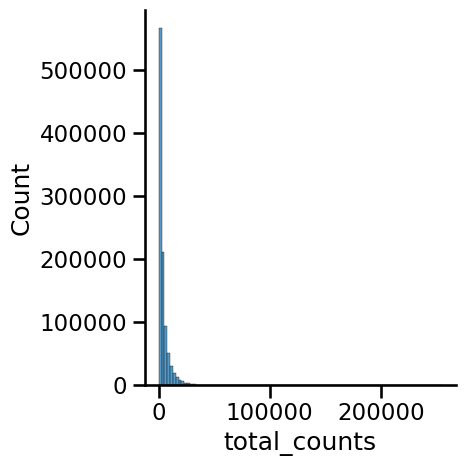

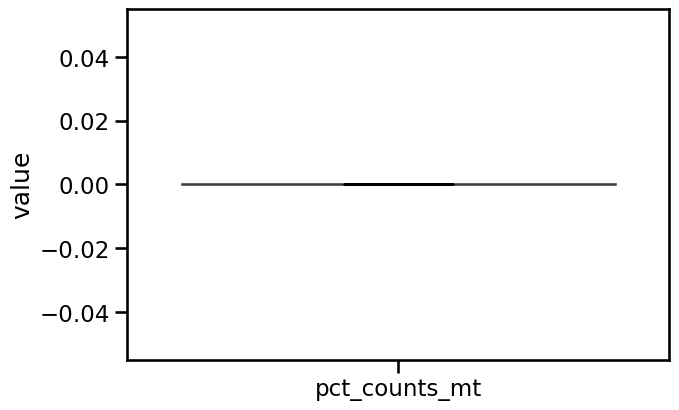

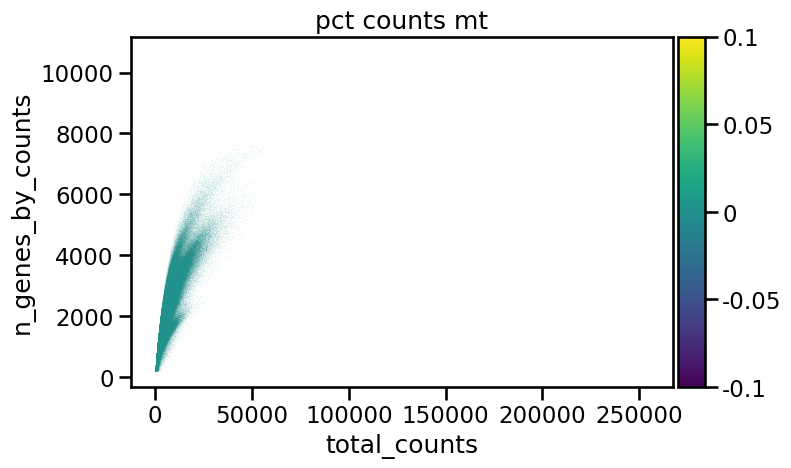

In [18]:
#Plot the three QC covariates: n_genes_by_counts, total_counts and pct_counts_mt:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

QC: automatic thresholding and filtering based on MAD

In [19]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [20]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    986252
True      24534
Name: count, dtype: int64

In [21]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    1010786
Name: count, dtype: int64

Now filter our object based on these two additional columns


In [22]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 1010786
Number of cells after filtering of low quality cells: 986252


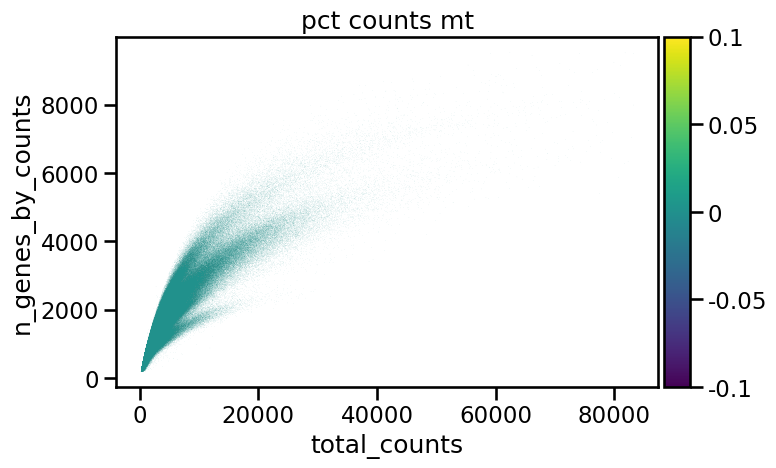

In [23]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Prepare for integraton

After QC, add layers

In [24]:
#counts layer
adata.layers['counts'] = adata.X.copy()

#normalized counts layer
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 986252 × 15849
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell_

## EDA of unintegrated data

In [25]:
adata.obs[batch_key].value_counts()

sample_ID
RICH1       18844
D503_BAL    15671
D520_LNG    15433
D496_LNG    13406
S19         13166
            ...  
137C          210
640C_LNG      150
244C          116
637C_LNG       74
S24            62
Name: count, Length: 253, dtype: int64

In [26]:
len(adata.obs[batch_key].value_counts())

253

### Visualization: to check if there is batch effects

In [ ]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

In [ ]:
plt.figure(figsize=(12, 8))  # Set the figure size to be larger
sc.pl.umap(adata, color=batch_key, show=False)
plt.title(f'UMAP: {batch_key} (Original)')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))  # Set the figure size to be larger
sc.pl.umap(adata, color=dataset_key, show=False)
plt.title(f'UMAP: {dataset_key} (Original)')
plt.show()

In [ ]:
adata.obs.file_name.unique()

### Batch-aware feature selection

In [27]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key
)
adata
adata.var

gene_symbols  n_cells     mt   ribo     hb  n_cells_by_counts  \
ensembl_id                                                                      
ENSG00000187634       SAMD11    25410  False  False  False              25410   
ENSG00000188976        NOC2L   180911  False  False  False             180911   
ENSG00000187961       KLHL17    47171  False  False  False              47171   
ENSG00000187583      PLEKHN1    50990  False  False  False              50990   
ENSG00000187642        PERM1     1840  False  False  False               1840   
...                      ...      ...    ...    ...    ...                ...   
ENSG00000160298     C21orf58    54232  False  False  False              54232   
ENSG00000160299         PCNT   111661  False  False  False             111661   
ENSG00000160305        DIP2A   163490  False  False  False             163490   
ENSG00000160307        S100B    21106  False  False  False              21106   
ENSG00000160310        PRMT2   323670  False  False  False             323670   

                 mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
ensembl_id                                                               
ENSG00000187634     0.030425           0.029971              97.486115   
ENSG00000188976     0.232757           0.209254              82.101948   
ENSG00000187961     0.056261           0.054735              95.333236   
ENSG00000187583     0.066778           0.064643              94.955411   
ENSG00000187642     0.001898           0.001896              99.817963   
...                      ...                ...                    ...   
ENSG00000160298     0.127429           0.119939              94.634670   
ENSG00000160299     0.141819           0.132623              88.953052   
ENSG00000160305     0.217020           0.196405              83.825459   
ENSG00000160307     0.085403           0.081951              97.911922   
ENSG00000160310     0.510496           0.412438              67.978385   

                 total_counts  log1p_total_counts  highly_variable     means  \
ensembl_id                                                                     
ENSG00000187634         30753           10.333775            False  0.018682   
ENSG00000188976        235268           12.368485            False  0.103716   
ENSG00000187961         56868           10.948506            False  0.028777   
ENSG00000187583         67498           11.119868            False  0.028538   
ENSG00000187642          1918            7.559559            False  0.000849   
...                       ...                 ...              ...       ...   
ENSG00000160298        128803           11.766047             True  0.038283   
ENSG00000160299        143349           11.873044            False  0.078218   
ENSG00000160305        219361           12.298479            False  0.122348   
ENSG00000160307         86324           11.365875             True  0.018524   
ENSG00000160310        516002           13.153868            False  0.222877   

                 dispersions  dispersions_norm  highly_variable_nbatches  \
ensembl_id                                                                 
ENSG00000187634     0.873684          0.884156                        56   
ENSG00000188976     0.770652          0.102725                        12   
ENSG00000187961     0.809719          0.298650                        10   
ENSG00000187583     0.794073          0.190202                        23   
ENSG00000187642     0.547613          0.081118                        15   
...                      ...               ...                       ...   
ENSG00000160298     0.901352          1.173602                        78   
ENSG00000160299     0.786385          0.273476                        23   
ENSG00000160305     0.824051          0.818263                        64   
ENSG00000160307     1.184764          3.878201                       160   
ENSG00000160310     0.761149          0.290685

highly_variable_nbatches
5      705
4      702
3      700
6      658
2      654
      ... 
219      1
229      1
230      1
214      1
233      1
Name: count, Length: 229, dtype: int64

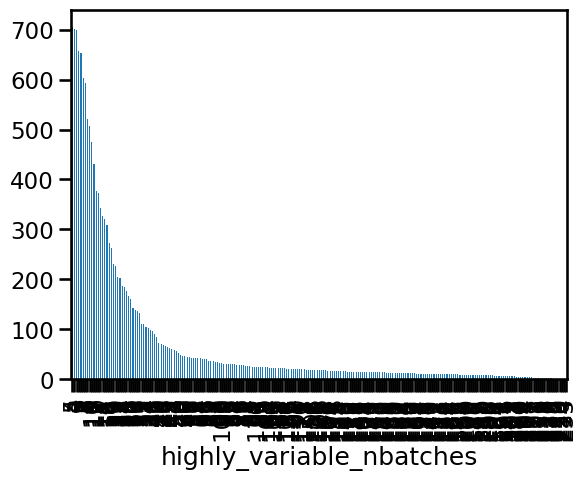

In [28]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [29]:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 986252 × 2000
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell_t

# (Can start from here) Save the adata_hvg

In [30]:
adata_hvg.write(hvg_path)

In [31]:
adata_hvg = sc.read(hvg_path)

# Data integration

## 1. Variational autoencoder based integration: scvi

- use raw counts

In [32]:
adata_scvi = adata_hvg.copy()

In [35]:
# data preparation
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key)
adata_scvi

AnnData object with n_obs × n_vars = 986252 × 2000
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell_t

In [36]:
#build the model
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [37]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'sample_ID',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │  253   │
│         n_cells          │ 986252 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  2000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                        batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_ID'] │       001C        │          0          │
│                        │       048C        │          1          │
│                        │       098C        │          2          │
│                        │       133C        │          3          │
│                        │       137C        │          4          │
│                        │       160C        │          5          │
│                        │       192C        │          6          │
│                        │       222C        │          7          │
│                        │       244C        │          8          │
│                        │       388C        │          9          │
│                        │       454C        │         10          │
│                        │     583B_LNG      │         11          │
│                        │     591C_LNG      │         12          │
│                        │     637C_LNG      │         13          │
│                        │     640C_LNG      │         14          │
│                        │     689C_LNG      │         15          │
│                        │     768B_LNG      │         16          │
│                        │     778C_LNG      │         17          │
│                        │       1372C       │         18          │
│                        │       A4-77       │         19          │
│                        │       A6-9        │         20          │
│                        │       A6-42       │         21          │
│                        │      A11-15       │         22          │
│                        │      A11-20       │         23          │
│                        │      A12-30       │         24          │
│                        │      A12-35       │         25          │
│                        │      A16-16       │         26          │
│                        │      A19-80       │         27          │
│                        │      A20-21       │         28          │
│                        │       A22-4       │         29          │
│                        │       A24-4       │         30          │
│                        │      A24-28       │         31          │
│                        │      A25-42       │         32          │
│                        │      A25-46       │         33          │
│                        │       A27-6       │         34          │
│                        │      A29-13       │         35          │
│                        │      A29-19       │         36          │
│                        │      A30-14       │         37          │
│                        │      A30-19       │         38          │
│                        │      A31-62       │         39          │
│                        │       A33-4       │         40          │
│                        │      A33-16       │         41          │
│                        │      A34-78       │         42          │
│                        │       A35-4       │         43          │
│                        │      A36-58       │         44          │
│                        │      A36-66       │         45          │
│                        │       A39-5       │         46          │
│                        │      A40-13       │         47          │
│                        │      A40-36       │         48          │
│                        │      A42-14       │         49          │
│                        │      A42-34       │         50          │
│                        │      A43-12       │         51          │
│                        │      A43-24       │         52          │
│                        │       A44-5       │         53          

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [ ]:
#Train
max_epochs_scvi = np.min([round((20000 / adata_hvg.n_obs) * 400), 400])
max_epochs_scvi

In [ ]:
model_scvi.train()

In [ ]:
#extract the embedding
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

In [ ]:
#calculate a batch-corrected UMAP
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
adata_scvi

### Plot

- dataset plot: make COPD/normal datasets in one color
- batch plot: add which batches are from which dataset
- cell_type plot


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

# Define custom colors for datasets
# Updated normal_palette with standard green
combined_palette = {
    'Yildirim_unpubl.h5ad': '#FF0000',  # Red
    'Kropski_Banovich_unpubl.h5ad': '#FF1493',  # Purple
    'Shaykhiev_publ.h5ad': '#FFC0CB',  # Pink
    'Schiller_unpubl.h5ad': '#FF6666',  # Pinkish Red
    'Nawijn_unpubl.h5ad': '#004d00',  # Dark Green
    'lungMAP.h5ad': '#00FF00',  # Standard Green
    'Jones_Yosef_Teichmann_Farber_Sims_unpubl.h5ad': '#9acd32',  # Yellow-Green
    'Niklason_Kaminski_publ.h5ad': '#1e90ff'  # Lake Blue
}




# Custom plot function with correct category order mapping
def plot_umap_custom(adata, color, title, palette_dict):
    plt.figure(figsize=(12, 8))
    
    # Extract categories in the correct order
    if adata.obs[color].dtype.name == 'category':
        unique_values = adata.obs[color].cat.categories
    else:
        unique_values = adata.obs[color].unique()
    
    print("Unique values for color in adata:", unique_values)
    
    # Create a palette list matching the order of unique values
    palette = [palette_dict.get(value, "#808080") for value in unique_values]
    
    # Debugging: Check the final palette
    print("Palette used for plotting:", palette)
    
    # Plot UMAP
    sc.pl.umap(adata, color=color, palette=palette, show=False)
    plt.title(title)
    plt.show()

# Use the function for plotting
plot_umap_custom(adata_scvi, dataset_key, f'UMAP: {dataset_key} (scVI)', combined_palette)


In [ ]:
#PLOT
batch_palette = sns.color_palette("husl", len(adata_hvg.obs[batch_key].unique()))
cell_type_palette = sns.color_palette("tab70", len(adata_hvg.obs[label_key].unique()))



def plot_umap(adata, color, title, palette):
    plt.figure(figsize=(12, 8))
    sc.pl.umap(adata, color=color, palette=palette, show=False)
    plt.title(title)
    plt.show()
    
plot_umap(adata_scvi, label_key, f'UMAP: {label_key} (scVI)', cell_type_palette)

## Graph-based integration: bbknn

In [ ]:
neighbors_within_batch = 25 if adata_hvg.n_obs > 100000 else 3
neighbors_within_batch

In [ ]:
adata_bbknn = adata_hvg.copy()
adata_bbknn.X = adata_bbknn.layers["logcounts"].copy()
sc.pp.pca(adata_bbknn)

In [ ]:
bbknn.bbknn(
    adata_bbknn, batch_key=batch_key, neighbors_within_batch=neighbors_within_batch
)
adata_bbknn

In [ ]:
sc.tl.umap(adata_bbknn)

In [ ]:
plot_umap_custom(adata_bbknn, dataset_key, f'UMAP: {dataset_key} (BBKNN)', combined_palette)

In [ ]:
plot_umap(adata_bbknn, label_key, f'UMAP: {label_key} (BBKNN)', cell_type_palette)

## Harmony

In [ ]:
adata_harmony = adata_hvg.copy()

In [ ]:
sce.pp.harmony_integrate(adata_harmony, batch_key)

In [ ]:
sc.tl.umap(adata_harmony)

In [ ]:
plot_umap_custom(adata_harmony, dataset_key, f'UMAP: {dataset_key} (Harmony)', combined_palette)

In [ ]:
plot_umap(adata_harmony, label_key, f'UMAP: {label_key} (Harmony)', cell_type_palette)

## Scanorama

In [ ]:
adata_scanorama = adata_hvg.copy()

In [ ]:
import scanorama

# Prepare data for Scanorama
batch_list = [adata_hvg[adata_hvg.obs[batch_key] == b].copy() for b in adata_hvg.obs[batch_key].unique()]
scanorama_integrated = scanorama.integrate_scanpy(batch_list, dimred=50)

# Concatenate results
adata_scanorama = batch_list[0].concatenate(*batch_list[1:], batch_key=batch_key)



In [ ]:
# Recompute neighbors and UMAP
sc.pp.neighbors(adata_scanorama, use_rep='X_scanorama')
sc.tl.umap(adata_scanorama)

# plt.figure(figsize=(12, 8))
# sc.pl.umap(adata_scanorama, color=batch_key, show=False)
# plt.title(f'UMAP: {batch_key} (Scanorama)')
# plt.show()


In [ ]:
plot_umap_custom(adata_scanorama, dataset_key, f'UMAP: {dataset_key} (Scanorama)', combined_palette)

In [ ]:
plot_umap(adata_scanorama, label_key, f'UMAP: {label_key} (Scanorama)', cell_type_palette)

# Benchmarking

In [ ]:
# metrics_scvi = scib.metrics.metrics_fast(
#     adata, adata_scvi, batch_key, label_key, embed="X_scVI"
# )
# # metrics_scanvi = scib.metrics.metrics_fast(
# #     adata, adata_scanvi, batch_key, label_key, embed="X_scANVI"
# # )
# metrics_bbknn = scib.metrics.metrics_fast(adata, adata_bbknn, batch_key, label_key)
# metrics_harmony = scib.metrics.metrics_fast(adata, adata_harmony, batch_key, label_key)
# metrics_scanorama = scib.metrics.metrics_fast(adata, adata_scanorama, batch_key, label_key)
# metrics_hvg = scib.metrics.metrics_fast(adata, adata_hvg, batch_key, label_key)

# Save adata for methods and benchmarking metrics

In [6]:
adata_scvi_path = './data/adata_scvi.h5ad'
adata = sc.read_h5ad(adata_scvi_path)
# adata_bbknn_path = './data/adata_bbknn.h5ad'
# adata_harmony_path = './data/adata_harmony.h5ad'
# adata_scanorama_path = './data/adata_scanorama.h5ad'

# adata_scvi = sc.read(adata_scvi_path)
# adata_bbknn = sc.read(adata_bbknn_path)
# adata_harmony = sc.read(adata_harmony_path)
# adata_scanorama = sc.read(adata_scanorama_path)

In [ ]:
#adata_scvi.write(adata_scvi_path)
# adata_bbknn.write(adata_bbknn_path)
# adata_harmony.write(adata_harmony_path)
# adata_scanorama.write(adata_scanorama_path)

# Downstream analysis

- batch covariate: pcr analsyis (performed on integrated object)

### Batch covariate analysis

In [7]:
# Load your integrated single-cell dataset (assuming an AnnData object)
adata = sc.read_h5ad(adata_scvi_path)

# Extract the integrated gene expression matrix (assume it's stored in 'X_integrated')
X_integrated = adata.X  

# Perform PCA on the integrated data
pca = PCA(n_components=10) 
pcs = pca.fit_transform(X_integrated)

# Store PCs in the AnnData object for reference
adata.obsm['X_pca_integrated'] = pcs

# Extract batch covariates (adjust column names as necessary)
batch_covariates = adata.obs[['author_cell_type', 'cell_type_ontology_term_id',
                              'sample_collection_relative_time_point', 'sample_ID',
                              'library_preparation_batch', 'donor_id',
                              'library_sequencing_run', 'sequencing_platform',
                              'sex_ontology_term_id', 'development_stage_ontology_term_id',
                              'assay_ontology_term_id', 'disease_ontology_term_id',
                              'cell_number_loaded', 'cell_viability_percentage',
                              'sample_collection_year','scanvi_labels','condition','sequenced_fragment']]

# Perform PCR (Principal Component Regression) analysis
results = {}

for covariate in batch_covariates.columns:
    print(f"Performing PCR for batch covariate: {covariate}")
    r2_values = []
    
    for i in range(pcs.shape[1]):
        pc = pd.to_numeric(pcs[:, i], errors='coerce')
        cov = pd.get_dummies(batch_covariates[covariate], drop_first=True).apply(pd.to_numeric, errors='coerce').fillna(0)
        cov = cov.astype(float)  # Ensure all covariate data is numeric
        model = sm.OLS(pc, sm.add_constant(cov)).fit()
        r2_values.append(model.rsquared)
    
    results[covariate] = r2_values

# Convert results to DataFrame
r2_df = pd.DataFrame(results, index=[f'PC{i+1}' for i in range(pcs.shape[1])])

Performing PCR for batch covariate: author_cell_type
Performing PCR for batch covariate: cell_type_ontology_term_id
Performing PCR for batch covariate: sample_collection_relative_time_point
Performing PCR for batch covariate: sample_ID
Performing PCR for batch covariate: library_preparation_batch
Performing PCR for batch covariate: donor_id
Performing PCR for batch covariate: library_sequencing_run
Performing PCR for batch covariate: sequencing_platform
Performing PCR for batch covariate: sex_ontology_term_id
Performing PCR for batch covariate: development_stage_ontology_term_id
Performing PCR for batch covariate: assay_ontology_term_id
Performing PCR for batch covariate: disease_ontology_term_id
Performing PCR for batch covariate: cell_number_loaded
Performing PCR for batch covariate: cell_viability_percentage
Performing PCR for batch covariate: sample_collection_year
Performing PCR for batch covariate: scanvi_labels
Performing PCR for batch covariate: condition
Performing PCR for bat

## Perform PCR all the whole integrated object

### on integrated

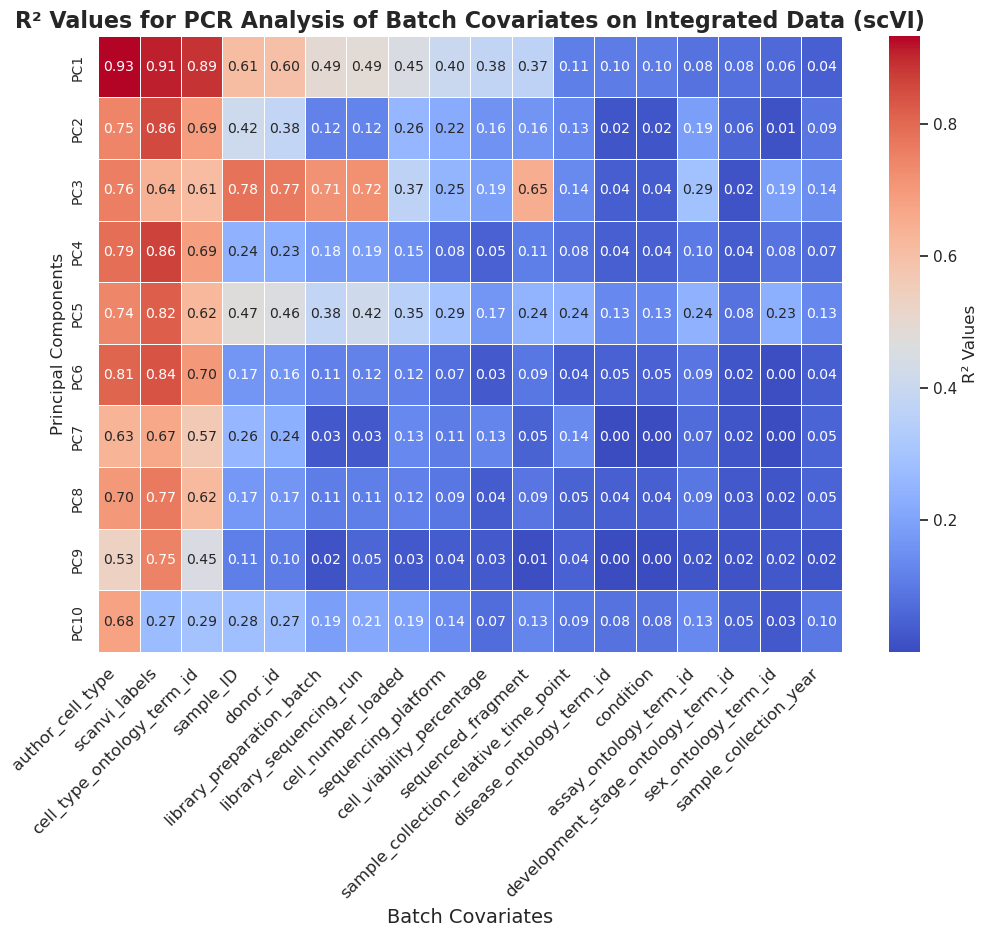

In [80]:
# Sort columns in descending order based on the first row
r2_df_sorted = r2_df.sort_values(by=r2_df.index[0], axis=1, ascending=False)

# Plot R² values
plt.figure(figsize=(12, 8))  # Increase figure size for better clarity
sns.set(style='whitegrid')  # Set a clean background
heatmap = sns.heatmap(
    r2_df_sorted,
    annot=True,
    cmap='coolwarm',  # Use a visually appealing color palette
    linewidths=0.5,
    annot_kws={"size": 10},  # Adjust annotation font size
    cbar_kws={"label": "R² Values"},  # Color bar label
    fmt='.2f'  # Format annotation to two decimal places
)

# Customize title and labels
plt.title('R² Values for PCR Analysis of Batch Covariates on Integrated Data (scVI)', fontsize=16, fontweight='bold')  # Increased title font size
plt.xlabel('Batch Covariates', fontsize=14)  # Increased x-axis label font size
plt.ylabel('Principal Components', fontsize=12)

# Adjust tick parameters
plt.xticks(rotation=45, ha='right', fontsize=12)  # Increased x-axis tick font size
plt.yticks(fontsize=10)

# Add grid lines for clarity
heatmap.grid(False)  # Disable default grid
plt.show()

# Optional: Save the R² values for further analysis
r2_df_sorted.to_csv('pcr_batch_covariates_r2_integrated_sorted.csv')


# todo: Biological analysis

- what's the cell type composition of outlier

- all_files = ['Kropski_Banovich_unpubl.h5ad', 'Shaykhiev_publ.h5ad', 'Schiller_unpubl.h5ad', 'Yildirim_unpubl.h5ad', #COPD+normal
             
             
             -'lungMAP.h5ad', 'Nawijn_unpubl.h5ad', 'Jones_Yosef_Teichmann_Farber_Sims_unpubl.h5ad','Niklason_Kaminski_publ.h5ad'] #Normal



## DEG analysis

### DEG on problematic_dataset = 'Kropski_Banovich_unpubl.h5ad'

In [7]:
# Specify the problematic dataset
problematic_dataset = 'Kropski_Banovich_unpubl.h5ad'

# Step 1: Differential Expression Analysis
# Create a boolean mask for the problematic dataset and others
mask_problematic = adata.obs['file_name'] == problematic_dataset
mask_other = adata.obs['file_name'] != problematic_dataset

# Perform differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='file_name', groups=[problematic_dataset], reference='rest', method='t-test')
result = adata.uns['rank_genes_groups']

# Extract results
de_genes = pd.DataFrame({
    'gene': result['names'][problematic_dataset],
    'pval': result['pvals'][problematic_dataset],
    'logfoldchanges': result['logfoldchanges'][problematic_dataset]
})


Number of significant genes: 1811


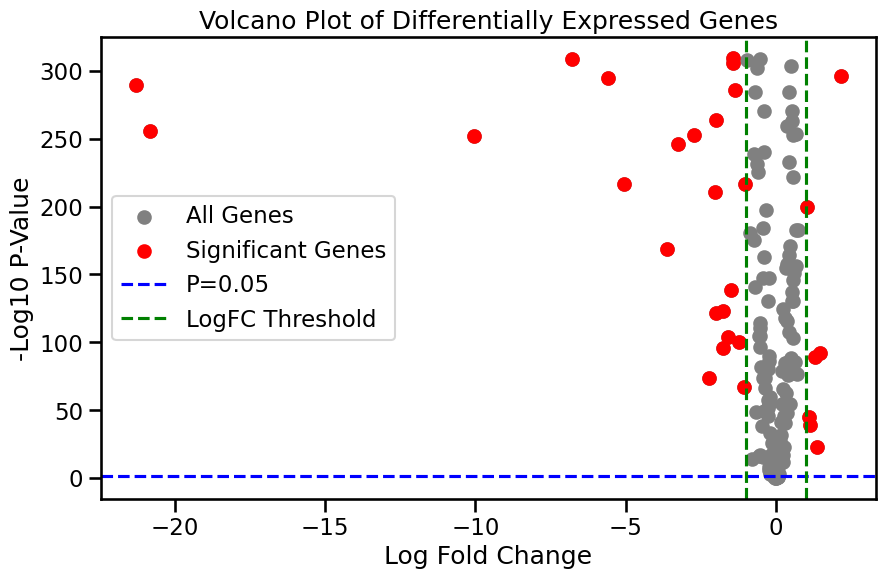

In [8]:
# Step 2: Filter Significant Genes
significant_genes = de_genes[(de_genes['pval'] < 0.05) & (de_genes['logfoldchanges'].abs() > 1)]  # Adjust thresholds as needed
print(f"Number of significant genes: {significant_genes.shape[0]}")

# Extract gene list for further analysis
gene_list = significant_genes['gene'].tolist()

# Step 3: Visualization
# Volcano Plot
plt.figure(figsize=(10, 6))
plt.scatter(de_genes['logfoldchanges'], -np.log10(de_genes['pval']), color='gray', label='All Genes')
plt.scatter(significant_genes['logfoldchanges'], -np.log10(significant_genes['pval']), color='red', label='Significant Genes')
plt.title('Volcano Plot of Differentially Expressed Genes')
plt.xlabel('Log Fold Change')
plt.ylabel('-Log10 P-Value')
plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--', label='P=0.05')  # Significance line
plt.axvline(x=1, color='green', linestyle='--', label='LogFC Threshold')  # LogFC threshold line
plt.axvline(x=-1, color='green', linestyle='--')
plt.legend()
plt.show()

### DEG on problematic_dataset = 'Kropski_Banovich_unpubl.h5ad' vs other COPD datasets

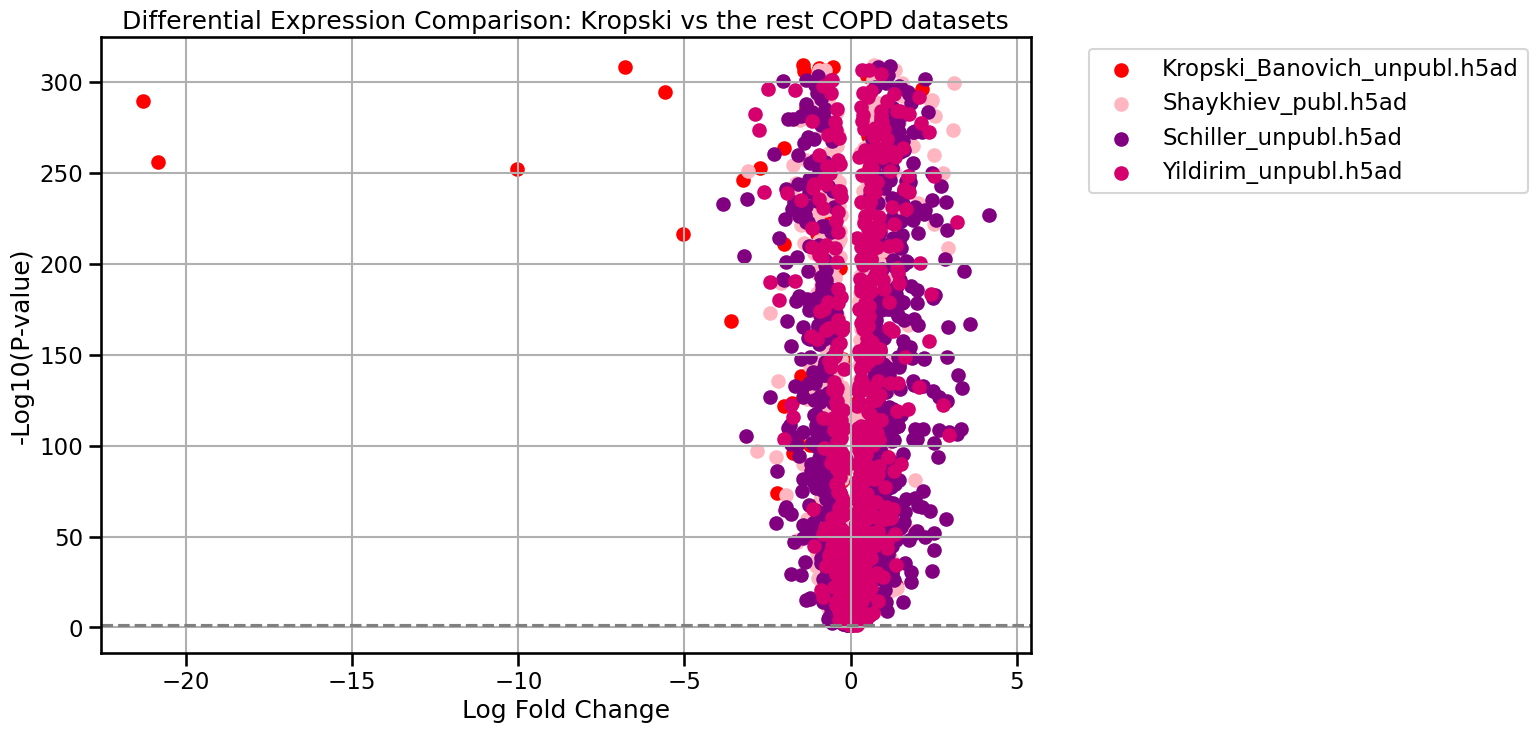

In [25]:
# Specify the problematic dataset and other COPD datasets
problematic_dataset = 'Kropski_Banovich_unpubl.h5ad'
other_datasets = ['Shaykhiev_publ.h5ad', 'Schiller_unpubl.h5ad', 'Yildirim_unpubl.h5ad']

# Define the custom color palette
combined_palette = {
    'Kropski_Banovich_unpubl.h5ad': '#FF0000',  # Other Pink
    'Yildirim_unpubl.h5ad': '#D5006D',  # Dark Pink
    'Shaykhiev_publ.h5ad': '#FFB6C1',  # Light Pink
    'Schiller_unpubl.h5ad': '#800080',  # Purple
    'Nawijn_unpubl.h5ad': '#004d00',  # Dark Green
    'lungMAP.h5ad': '#00FF00',  # Standard Green
    'Jones_Yosef_Teichmann_Farber_Sims_unpubl.h5ad': '#9acd32',  # Yellow-Green
    'Niklason_Kaminski_publ.h5ad': '#90EE90'  # Light Green
}

# Step 1: Differential Expression Analysis for the problematic dataset
sc.tl.rank_genes_groups(adata, groupby='file_name', groups=[problematic_dataset], reference='rest', method='t-test')
result = adata.uns['rank_genes_groups']

# Extract results for the problematic dataset
de_genes_problematic = pd.DataFrame({
    'gene': result['names'][problematic_dataset],
    'pval': result['pvals'][problematic_dataset],
    'logfoldchanges': result['logfoldchanges'][problematic_dataset]
})

# Filter significant genes for the problematic dataset
de_genes_problematic = de_genes_problematic[de_genes_problematic['pval'] < 0.05]  # Adjust threshold as needed

# Step 2: Differential Expression Analysis for other datasets
combined_results = de_genes_problematic.assign(dataset=problematic_dataset)  # Start with the problematic dataset

for dataset in other_datasets:
    sc.tl.rank_genes_groups(adata, groupby='file_name', groups=[dataset], reference='rest', method='t-test')
    result = adata.uns['rank_genes_groups']
    
    # Extract results for the current dataset
    de_genes_other = pd.DataFrame({
        'gene': result['names'][dataset],
        'pval': result['pvals'][dataset],
        'logfoldchanges': result['logfoldchanges'][dataset]
    })
    
    # Filter significant genes for the current dataset
    de_genes_other = de_genes_other[de_genes_other['pval'] < 0.05]  # Adjust threshold as needed
    de_genes_other['dataset'] = dataset

    combined_results = pd.concat([combined_results, de_genes_other])

# Step 3: Visualization
plt.figure(figsize=(12, 8))
plt.scatter(de_genes_problematic['logfoldchanges'], -np.log10(de_genes_problematic['pval']), 
            color=combined_palette[problematic_dataset], label=problematic_dataset)

for dataset in other_datasets:
    subset = combined_results[combined_results['dataset'] == dataset]
    plt.scatter(subset['logfoldchanges'], -np.log10(subset['pval']), 
                color=combined_palette[dataset], label=dataset)

plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')  # Significance threshold line
plt.title('Differential Expression Comparison: Kropski vs the rest COPD datasets')
plt.xlabel('Log Fold Change')
plt.ylabel('-Log10(P-value)')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid()
plt.show()


### DEG on problematic_dataset vs other normal datasets

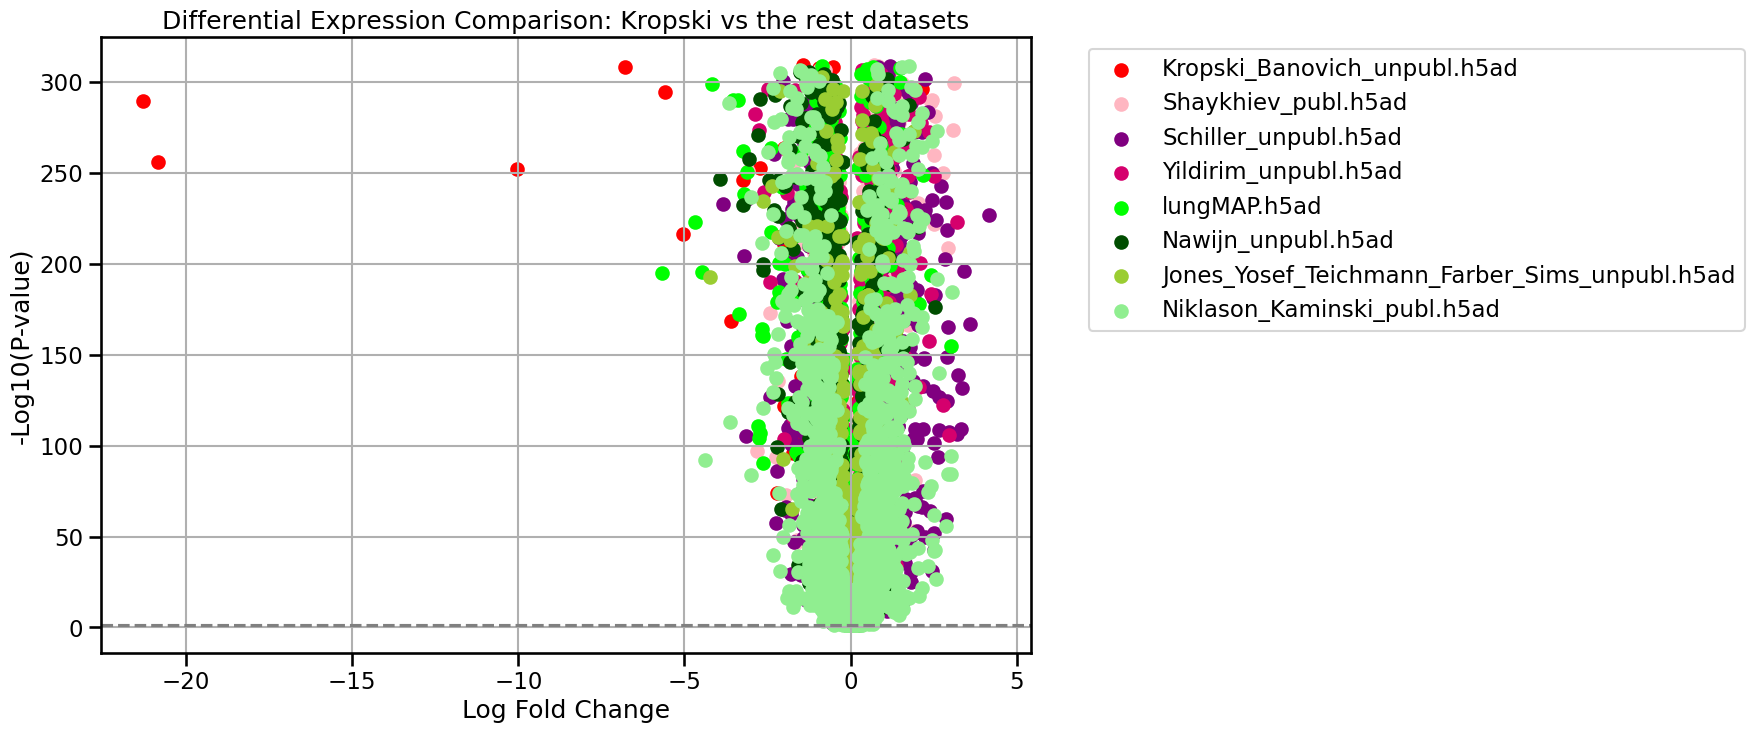

In [26]:
# Specify the problematic dataset, other COPD datasets, and normal datasets
problematic_dataset = 'Kropski_Banovich_unpubl.h5ad'
other_copd_datasets = ['Shaykhiev_publ.h5ad', 'Schiller_unpubl.h5ad', 'Yildirim_unpubl.h5ad']
normal_datasets = ['lungMAP.h5ad', 'Nawijn_unpubl.h5ad', 'Jones_Yosef_Teichmann_Farber_Sims_unpubl.h5ad', 'Niklason_Kaminski_publ.h5ad']

# Step 1: Differential Expression Analysis for the problematic dataset
sc.tl.rank_genes_groups(adata, groupby='file_name', groups=[problematic_dataset], reference='rest', method='t-test')
result = adata.uns['rank_genes_groups']

# Extract results for the problematic dataset
de_genes_problematic = pd.DataFrame({
    'gene': result['names'][problematic_dataset],
    'pval': result['pvals'][problematic_dataset],
    'logfoldchanges': result['logfoldchanges'][problematic_dataset]
})

# Display significant genes for the problematic dataset
de_genes_problematic = de_genes_problematic[de_genes_problematic['pval'] < 0.05] 

# Step 2: Differential Expression Analysis for other COPD datasets
combined_results = de_genes_problematic.assign(dataset=problematic_dataset)  # Start with the problematic dataset

for dataset in other_copd_datasets:
    sc.tl.rank_genes_groups(adata, groupby='file_name', groups=[dataset], reference='rest', method='t-test')
    result = adata.uns['rank_genes_groups']
    
    # Extract results for the current dataset
    de_genes_other = pd.DataFrame({
        'gene': result['names'][dataset],
        'pval': result['pvals'][dataset],
        'logfoldchanges': result['logfoldchanges'][dataset]
    })
    
    # Display significant genes for the current dataset
    de_genes_other = de_genes_other[de_genes_other['pval'] < 0.05]  
    de_genes_other['dataset'] = dataset
    
    # Append results to the combined DataFrame
    combined_results = pd.concat([combined_results, de_genes_other])

# Step 3: Differential Expression Analysis for normal datasets
for dataset in normal_datasets:
    sc.tl.rank_genes_groups(adata, groupby='file_name', groups=[dataset], reference='rest', method='t-test')
    result = adata.uns['rank_genes_groups']
    
    # Extract results for the current normal dataset
    de_genes_normal = pd.DataFrame({
        'gene': result['names'][dataset],
        'pval': result['pvals'][dataset],
        'logfoldchanges': result['logfoldchanges'][dataset]
    })
    
    # Display significant genes for the current normal dataset
    de_genes_normal = de_genes_normal[de_genes_normal['pval'] < 0.05]  # Adjust threshold as needed
    de_genes_normal['dataset'] = dataset
    
    # Append results to the combined DataFrame
    combined_results = pd.concat([combined_results, de_genes_normal])

# Step 4: Visualization 
plt.figure(figsize=(12, 8))

# Plot problematic dataset
plt.scatter(de_genes_problematic['logfoldchanges'], -np.log10(de_genes_problematic['pval']), 
            color=combined_palette[problematic_dataset], label=problematic_dataset)

# Plot other COPD datasets with their respective colors
for dataset in other_copd_datasets:
    subset = combined_results[combined_results['dataset'] == dataset]
    plt.scatter(subset['logfoldchanges'], -np.log10(subset['pval']), 
                color=combined_palette[dataset], label=dataset)

# Plot normal datasets with their respective colors
for dataset in normal_datasets:
    subset = combined_results[combined_results['dataset'] == dataset]
    plt.scatter(subset['logfoldchanges'], -np.log10(subset['pval']), 
                color=combined_palette[dataset], label=dataset)

plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')  # Significance threshold line
plt.title('Differential Expression Comparison: Kropski vs the rest datasets')
plt.xlabel('Log Fold Change')
plt.ylabel('-Log10(P-value)')

# Position the legend outside of the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid()
plt.show()


# COPD-specific gene analysis

In [11]:
#Load the data
adata_scvi_path = './data/adata_scvi.h5ad'
adata = sc.read_h5ad(adata_scvi_path)

In [12]:
unique_labels = adata.obs['scanvi_labels'].unique().tolist()
print(unique_labels)

['CD4 T cells', 'AT2', 'Multiciliated (non-nasal)', 'Alveolar fibroblasts', 'Alveolar macrophages', 'Non-classical monocytes', 'Suprabasal', 'B cells', 'pre-TB secretory', 'CD8 T cells', 'Alveolar Mph proliferating', 'EC aerocyte capillary', 'Monocyte-derived Mph', 'Peribronchial fibroblasts', 'Basal resting', 'EC general capillary', 'Alveolar Mph CCL3+', 'Alveolar Mph MT-positive', 'Ionocyte', 'NK cells', 'AT1', 'Smooth muscle', 'Interstitial Mph perivascular', 'Club (nasal)', 'EC venous pulmonary', 'Mast cells', 'DC2', 'Adventitial fibroblasts', 'Goblet (nasal)', 'EC venous systemic', 'Plasmacytoid DCs', 'Classical monocytes', 'SMG mucous', 'DC1', 'Pericytes', 'Goblet (bronchial)', 'SM activated stress response', 'Club (non-nasal)', 'Lymphatic EC mature', 'Lymphatic EC proliferating', 'SMG duct', 'SMG serous (bronchial)', 'Lymphatic EC differentiating', 'Hillock-like', 'Mesothelium', 'EC arterial', 'Myofibroblasts', 'AT2 proliferating', 'Multiciliated (nasal)', 'AT0', 'T cells prolif

#### Define COPD marker genes, define palettes for datasets

In [14]:
marker_genes = {
    'AT2': ['FGG', 'AZGP1', 'HHIP', 'SFTPD', 'CMTM8', 'EPAS1', 'KRT7', 'MAOA', 'PTPN12', 'QKI', 'RTN4', 'STOM', 'TGFBR2'],
    'Classical monocytes': ['CCL19', 'IL1B', 'KLF4', 'ACVRL1', 'CD79B', 'ENG', 'EPAS1', 'GABARAPL1', 'HPCAL1', 'NEDD9', 'PAG1', 'PAPSS2', 'PECAM1', 'PKN1', 'PTPN12', 'QKI', 'RTN4', 'S100A8', 'STOM', 'VIPR1'],
    'Alveolar macrophages': ['PLA2G7', 'MKI67', 'TOP2A', 'NUSAP1', 'ACVRL1', 'ASRGL1', 'CCR7', 'GABARAPL1', 'PAG1', 'QKI', 'RTN4', 'S100A8', 'SLC4A8', 'STX12'],
    'Club (nasal)': ['TIE1', 'IL7R'],
    # 'Club (non-nasal)': ['TIE1', 'IL7R'],
    'CD4 T cells': ['SYNE2', 'GLCCI1', 'CCR7', 'EPAS1', 'FCN3', 'QKI', 'STOM'],
    'T cells proliferating': ['CCR7', 'FCN3', 'OSBPL3', 'STOM'],
    'B cells': ['CCR7', 'FCN3', 'FCRLA'],
    'NK cells': ['EPAS1', 'FCN3', 'KLF13', 'PTPN12'],
    'Multiciliated (non-nasal)': ['ATP2C2', 'DHRS9', 'KLHL6', 'PKN1', 'RTN4', 'SLC4A8'],
    'Multiciliated (nasal)': ['DHRS9', 'S100A8'],
    'Alveolar Mph proliferating': ['CD79B'],
    'EC aerocyte capillary': ['ENG', 'RTN4', 'SMAD6', 'TACC1'],
    'Lymphatic EC mature': ['CRMP1'],
    'AT1': ['TACC1']
}


In [15]:
# Define color palette
combined_palette = {
    'Kropski_Banovich_unpubl.h5ad': '#FF0000',  # Red
    'Yildirim_unpubl.h5ad': '#D5006D',  # Dark Pink
    'Shaykhiev_publ.h5ad': '#FFB6C1',  # Light Pink
    'Schiller_unpubl.h5ad': '#800080',  # Purple
    'Nawijn_unpubl.h5ad': '#004d00',  # Dark Green
    'lungMAP.h5ad': '#00FF00',  # Standard Green
    'Jones_Yosef_Teichmann_Farber_Sims_unpubl.h5ad': '#9acd32',  # Yellow-Green
    'Niklason_Kaminski_publ.h5ad': '#90EE90'  # Light Green
}

In [16]:
mask_problematic = adata.obs['file_name'] == problematic_dataset   

### Kropski_Banovich_unpubl: 

#### 1. Average expression for COPD-specific cell type gene signatures

#### 2. Run differential expression analysis for all cell types (vs the rest)

For AT2, the following genes are not in the dataset: ['CMTM8', 'MAOA', 'PTPN12', 'QKI', 'RTN4', 'STOM', 'TGFBR2']
For Classical monocytes, the following genes are not in the dataset: ['GABARAPL1', 'HPCAL1', 'NEDD9', 'PKN1', 'PTPN12', 'QKI', 'RTN4', 'STOM']
For Alveolar macrophages, the following genes are not in the dataset: ['GABARAPL1', 'QKI', 'RTN4', 'SLC4A8', 'STX12']
Average expression for Club (nasal) in Kropski_Banovich_unpubl.h5ad: 0.0002564496244303882
For CD4 T cells, the following genes are not in the dataset: ['QKI', 'STOM']
For T cells proliferating, the following genes are not in the dataset: ['OSBPL3', 'STOM']
Average expression for B cells in Kropski_Banovich_unpubl.h5ad: 3.2815252779982984e-05
For NK cells, the following genes are not in the dataset: ['KLF13', 'PTPN12']
For Multiciliated (non-nasal), the following genes are not in the dataset: ['ATP2C2', 'DHRS9', 'PKN1', 'RTN4', 'SLC4A8']
For Multiciliated (nasal), the following genes are not in the dataset: ['DHRS9']


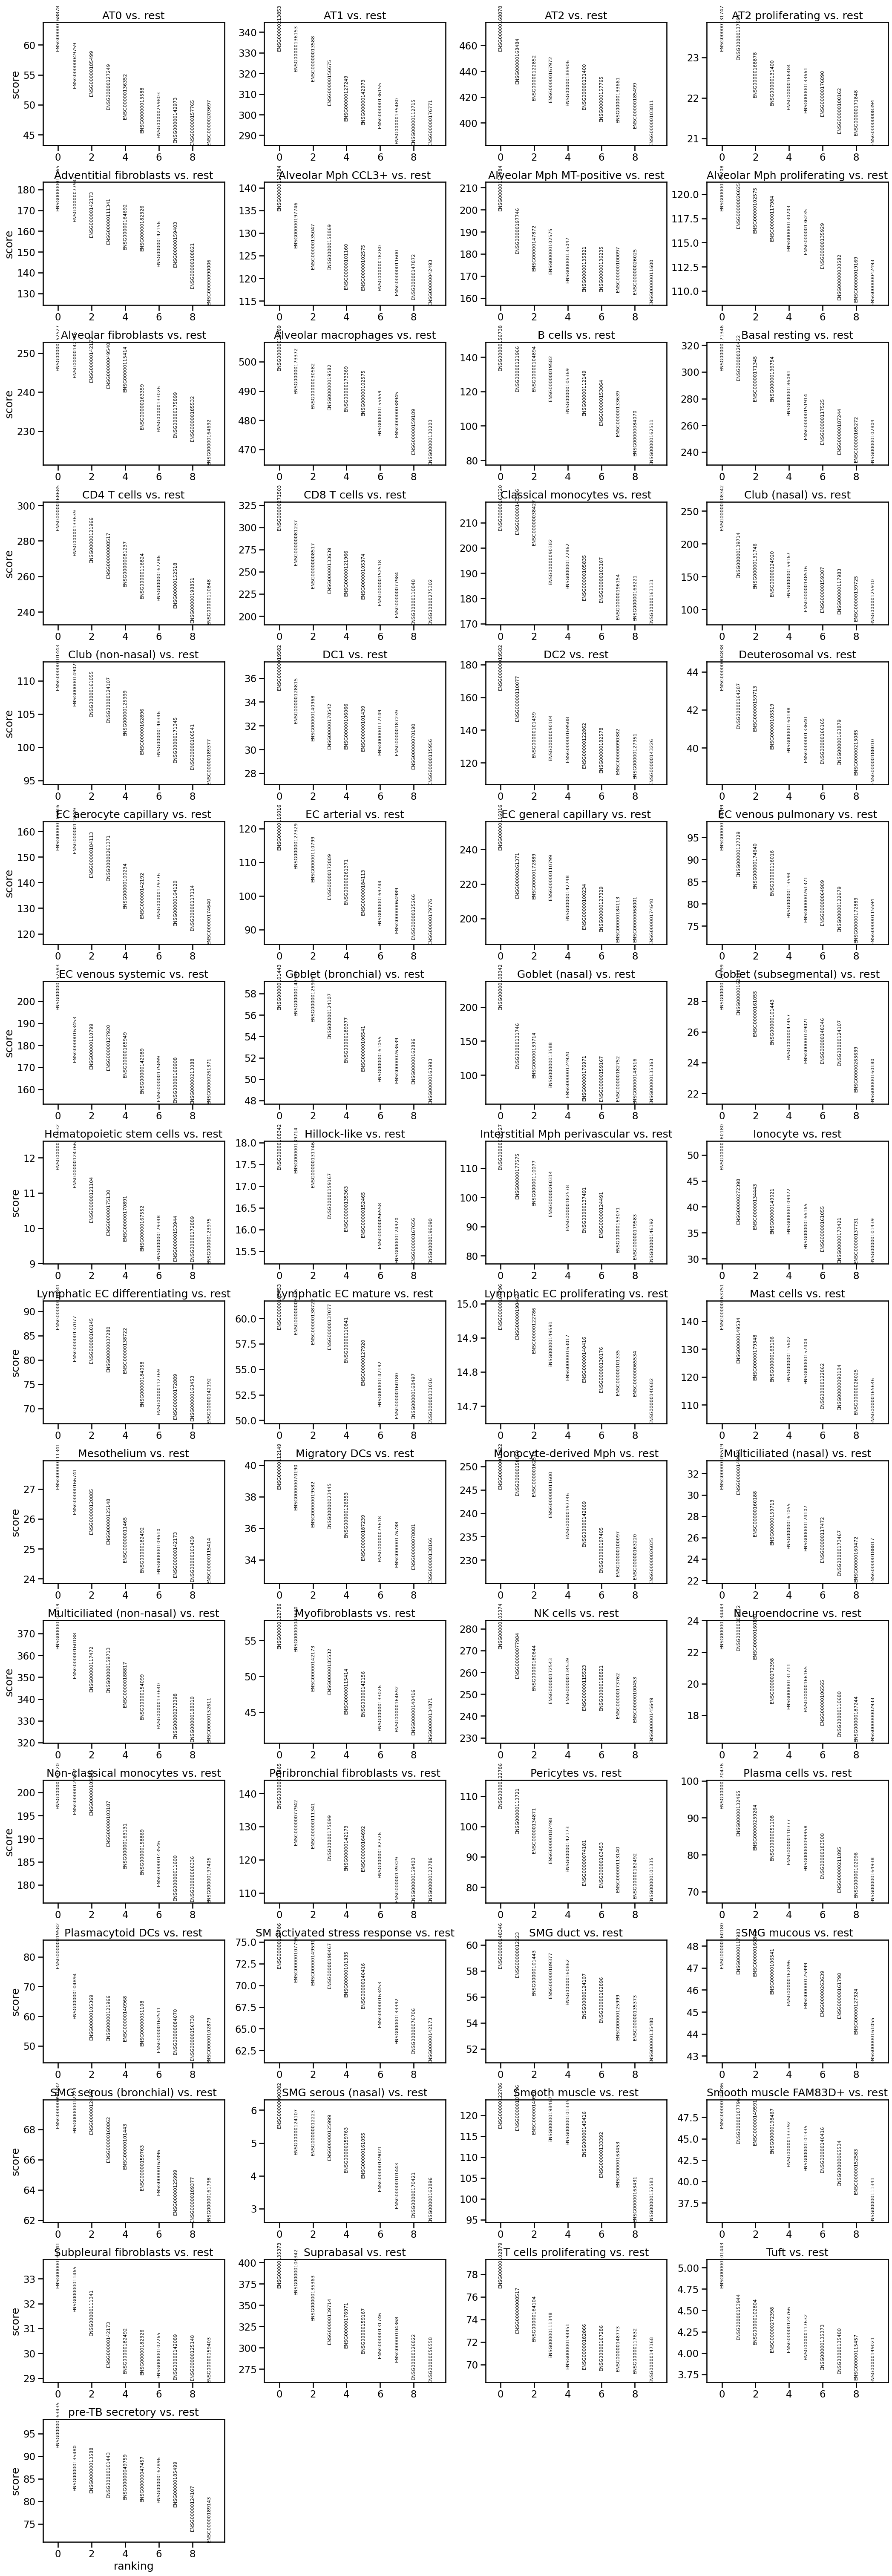

In [17]:
 # Calculate average expression of marker genes in the problematic dataset
for cell_type, genes in marker_genes.items():
    missing_genes = [g for g in genes if g not in adata.var.gene_symbols.tolist()]

    if not missing_genes:  # If there are no missing genes
        avg_expr = adata[mask_problematic].X[:, adata.var.gene_symbols.isin(genes)].mean(axis=1)
        print(f'Average expression for {cell_type} in {problematic_dataset}: {np.mean(avg_expr)}')
    else:
        print(f'For {cell_type}, the following genes are not in the dataset: {missing_genes}')

# Run differential expression analysis for a specific grouping
sc.tl.rank_genes_groups(adata, groupby='scanvi_labels', method='wilcoxon', n_genes=10)

# Visualize differential expression results
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

### per COPD dataset: expression of COPD marker genes 

No valid genes for Lymphatic EC mature.
No valid genes for AT1.


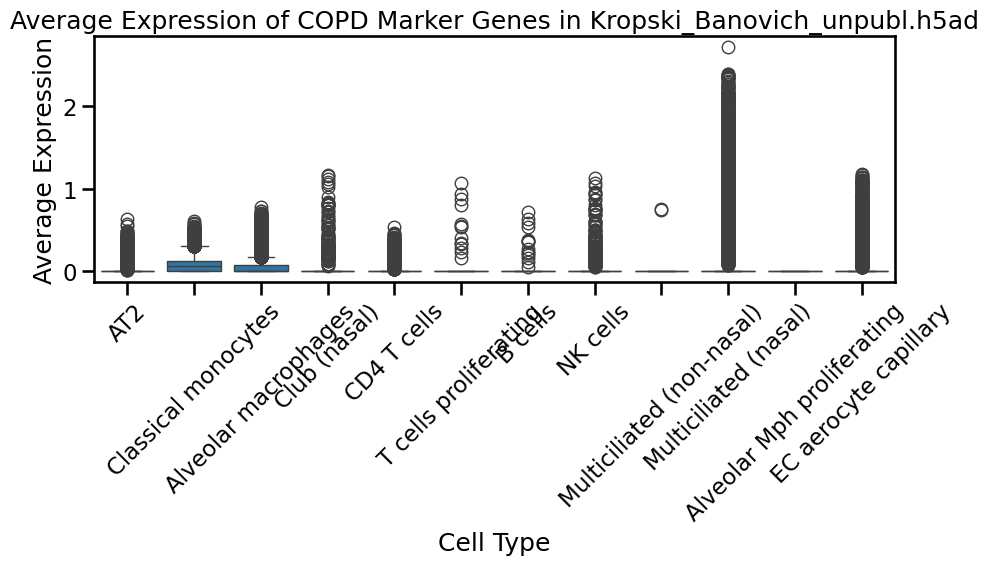

No valid genes for Lymphatic EC mature.
No valid genes for AT1.


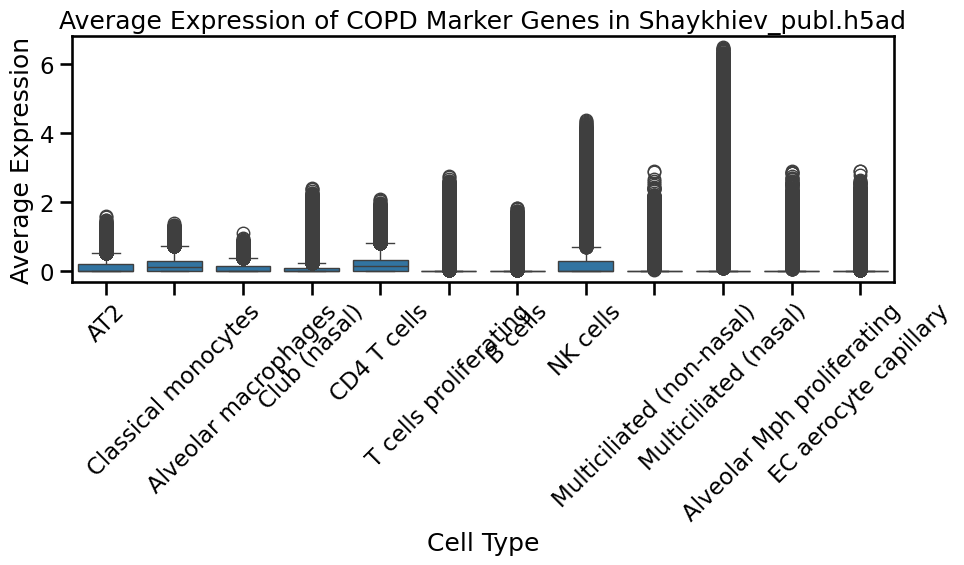

No valid genes for Lymphatic EC mature.
No valid genes for AT1.


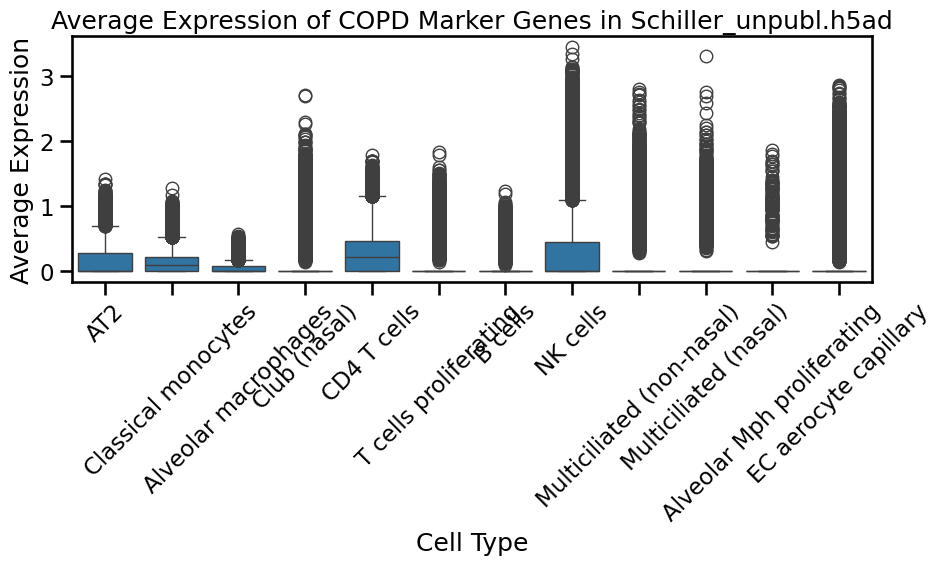

No valid genes for Lymphatic EC mature.
No valid genes for AT1.


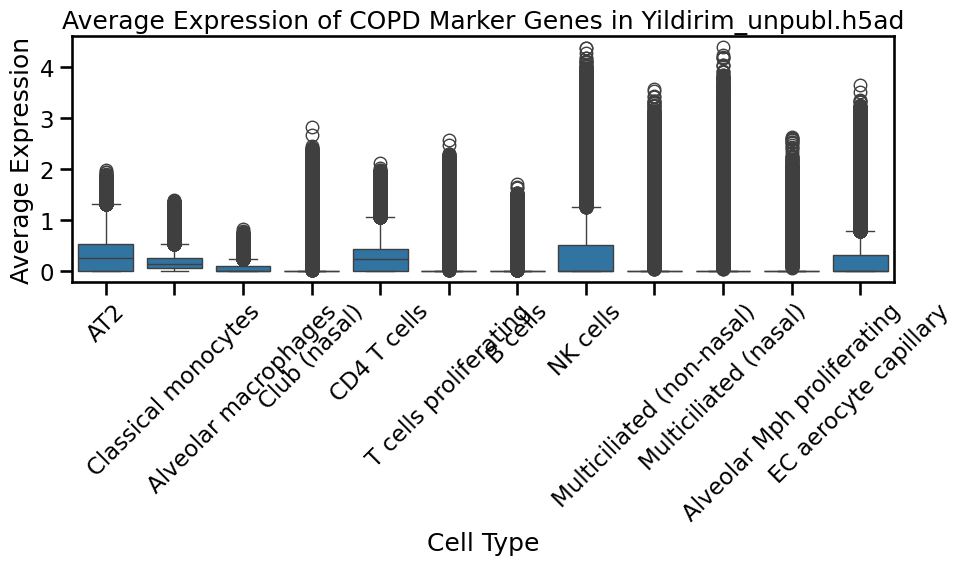

In [18]:
# List of other COPD datasets
other_copd_datasets = ['Shaykhiev_publ.h5ad', 'Schiller_unpubl.h5ad', 'Yildirim_unpubl.h5ad']

# Function to calculate and plot average expression for a given dataset
def calculate_and_plot_average_expression(dataset_name):
    # Mask for the dataset
    mask = adata.obs['file_name'] == dataset_name
    adata_subset = adata[mask]

    scores_df = pd.DataFrame(index=adata_subset.obs.index)

    # Calculate average expression for each cell type
    for cell_type, genes in marker_genes.items():
        valid_genes = [g for g in genes if g in adata.var.gene_symbols.tolist()]

        if valid_genes:
            # Get the integer indices of the valid genes
            gene_indices = np.where(adata.var.gene_symbols.isin(valid_genes))[0]

            # Check if gene_indices is not empty
            if gene_indices.size > 0:
                # Select the expression values using integer indices
                expr_values = adata_subset.X[:, gene_indices]

                # Calculate mean expression across valid genes
                avg_expr = np.mean(expr_values.toarray(), axis=1).flatten()  # Convert sparse matrix to dense

                scores_df[cell_type] = avg_expr
            else:
                print(f'No valid indices found for {cell_type}.')
        else:
            print(f'No valid genes for {cell_type}.')

    # Prepare for visualization
    scores_df = scores_df.melt(var_name='Cell Type', value_name='Average Expression')

    # Visualize the results
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=scores_df, x='Cell Type', y='Average Expression')
    plt.title(f'Average Expression of COPD Marker Genes in {dataset_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Calculate and plot for each COPD dataset
for dataset in [problematic_dataset] + other_copd_datasets:
    calculate_and_plot_average_expression(dataset)


### all datasets: average expression 

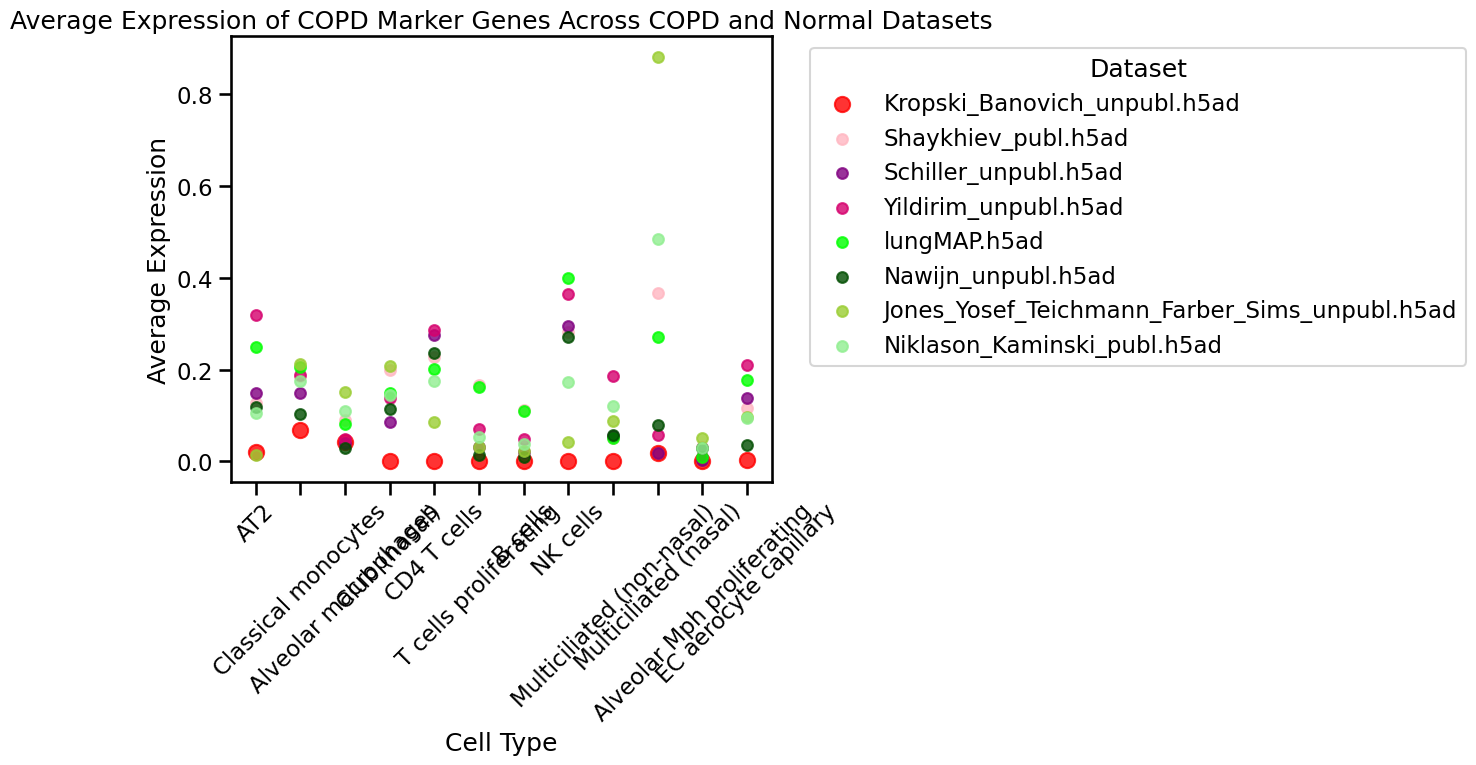

In [19]:
# Combine COPD and normal datasets
datasets = [problematic_dataset] + other_copd_datasets + normal_datasets

# Function to calculate average expression for a dataset
def calculate_average_expression(adata, marker_genes):
    scores_df = pd.DataFrame(index=adata.obs.index)
    
    for cell_type, genes in marker_genes.items():
        valid_genes = [g for g in genes if g in adata.var.gene_symbols.tolist()]
        
        if valid_genes:
            gene_indices = np.where(adata.var.gene_symbols.isin(valid_genes))[0]
            
            if gene_indices.size > 0:
                expr_values = adata.X[:, gene_indices]
                avg_expr = np.mean(expr_values.toarray(), axis=1).flatten()
                scores_df[cell_type] = avg_expr
    
    return scores_df.mean(axis=0).to_frame().T

# Initialize a list to store data
combined_scores = []

# Calculate and combine scores for each dataset
for dataset in datasets:
    mask = adata.obs['file_name'] == dataset
    adata_subset = adata[mask]
    
    avg_expr = calculate_average_expression(adata_subset, marker_genes)
    avg_expr['dataset'] = dataset
    combined_scores.append(avg_expr)

# Concatenate all the results
combined_scores_df = pd.concat(combined_scores, ignore_index=True)

# Melt the DataFrame for easy plotting
plot_df = combined_scores_df.melt(id_vars='dataset', var_name='Cell Type', value_name='Average Expression')

# Create a dot plot with larger dots for the problematic dataset
plt.figure(figsize=(14, 8))
for dataset in datasets:
    subset = plot_df[plot_df['dataset'] == dataset]
    plt.scatter(
        x=subset['Cell Type'], 
        y=subset['Average Expression'], 
        label=dataset,
        color=combined_palette[dataset],
        s=120 if dataset == problematic_dataset else 60,  # Bigger size for problematic dataset
        alpha=0.8
    )

plt.title('Average Expression of COPD Marker Genes Across COPD and Normal Datasets')
plt.xticks(rotation=45)
plt.xlabel('Cell Type')
plt.ylabel('Average Expression')

# Place the legend outside of the plot
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### per COPD dataset: within dataset copd vs normal

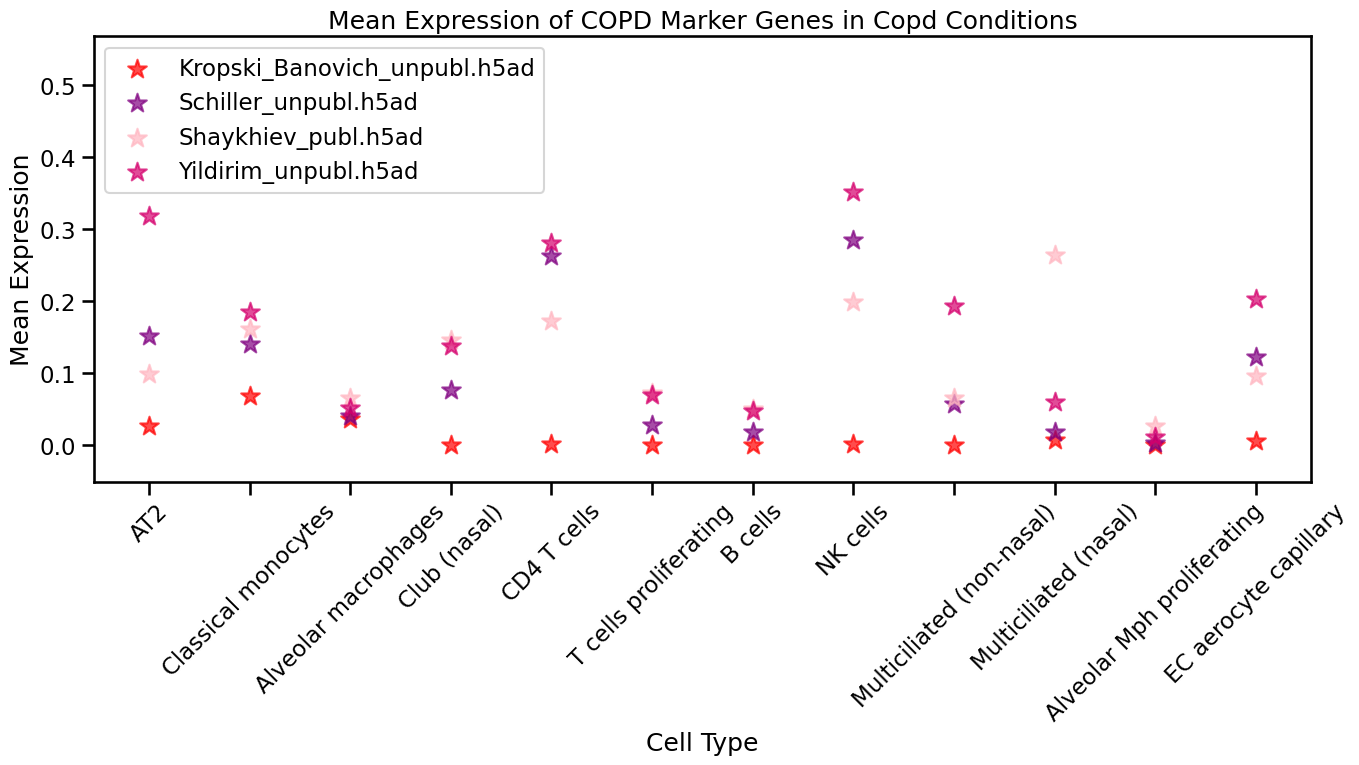

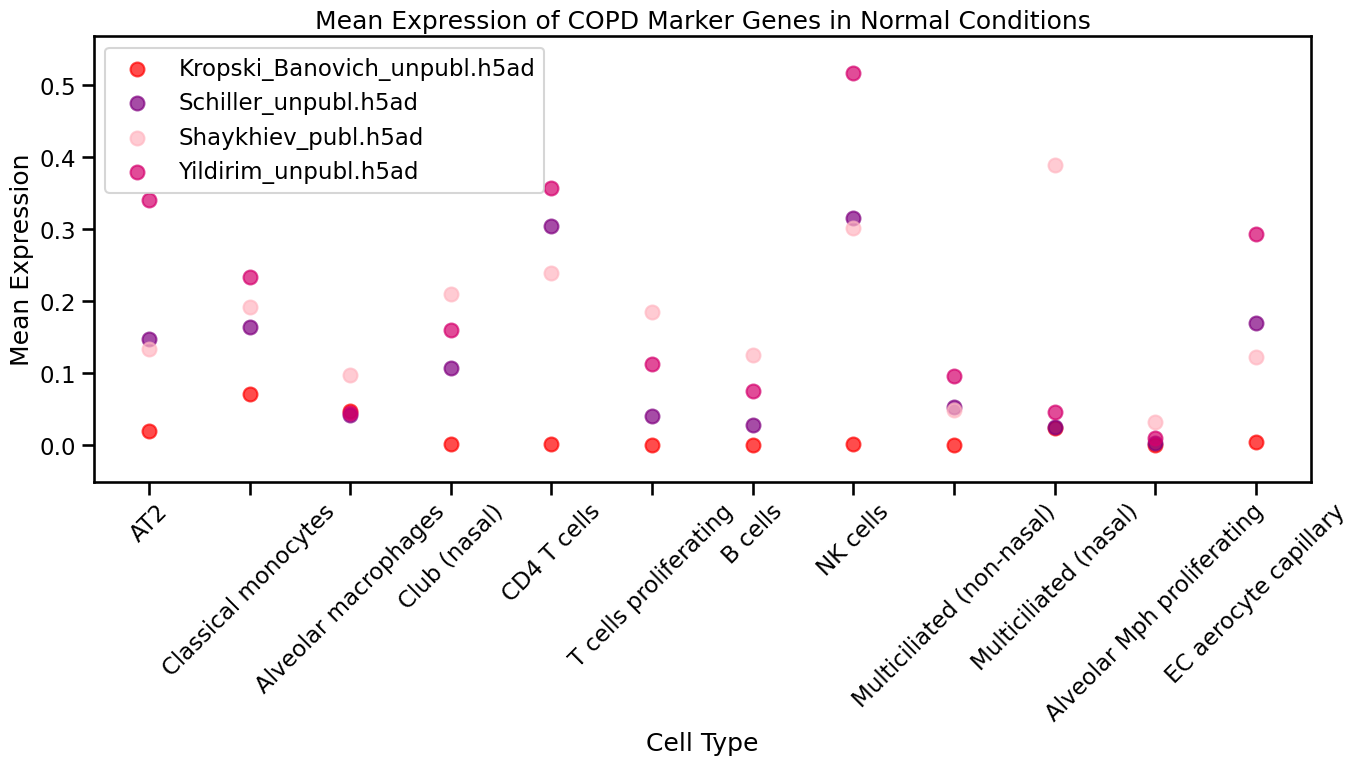

In [21]:
# Function to calculate average expression for a dataset
def calculate_average_expression(adata, marker_genes):
    scores_df = pd.DataFrame(index=adata.obs.index)
    
    for cell_type, genes in marker_genes.items():
        valid_genes = [g for g in genes if g in adata.var.gene_symbols.tolist()]
        
        if valid_genes:
            gene_indices = np.where(adata.var.gene_symbols.isin(valid_genes))[0]
            
            if gene_indices.size > 0:
                expr_values = adata.X[:, gene_indices]
                avg_expr = np.mean(expr_values.toarray(), axis=1).flatten()
                scores_df[cell_type] = avg_expr
    
    return scores_df

# Initialize a list to store combined data
combined_data = []

# Loop through each dataset for plotting
datasets = [problematic_dataset] + other_copd_datasets
for dataset in datasets:
    mask = adata.obs['file_name'] == dataset
    adata_subset = adata[mask]
    
    # Calculate average expression
    avg_expr_df = calculate_average_expression(adata_subset, marker_genes)
    avg_expr_df['condition'] = adata_subset.obs['condition'].values
    avg_expr_df['dataset'] = dataset
    combined_data.append(avg_expr_df)

# Combine all datasets
combined_df = pd.concat(combined_data, ignore_index=True)

# Calculate mean for each dataset and condition
mean_df = combined_df.groupby(['condition', 'dataset']).mean().reset_index()

# Melt the DataFrame for easy plotting
plot_df = mean_df.melt(id_vars=['condition', 'dataset'], var_name='Cell Type', value_name='Mean Expression')

# Get overall min and max for y-axis scaling
y_min = plot_df['Mean Expression'].min()
y_max = plot_df['Mean Expression'].max()

# Define a margin to extend the y-axis limits
margin = (y_max - y_min) * 0.1  # 10% margin

# Create plots for COPD and Normal conditions
for cond in ['copd', 'normal']:
    plt.figure(figsize=(14, 8))
    
    subset = plot_df[plot_df['condition'] == cond]
    
    for dataset in subset['dataset'].unique():
        dataset_subset = subset[subset['dataset'] == dataset]
        
        plt.scatter(
            x=dataset_subset['Cell Type'], 
            y=dataset_subset['Mean Expression'], 
            label=dataset,
            color=combined_palette[dataset],
            s=200 if cond == 'copd' else 100,  # Larger size for both conditions
            marker='*' if cond == 'copd' else 'o',  # Star for COPD, round for normal
            alpha=0.7  # Slightly lower alpha for better visibility
        )

    plt.title(f'Mean Expression of COPD Marker Genes in {cond.capitalize()} Conditions')
    plt.xticks(rotation=45)
    plt.xlabel('Cell Type')
    plt.ylabel('Mean Expression')
    plt.ylim(y_min - margin, y_max + margin)  # Set y-axis limits with margin
    plt.legend(loc='upper left')  # Place legend inside the graph
    plt.tight_layout()
    plt.show()


### per cell type

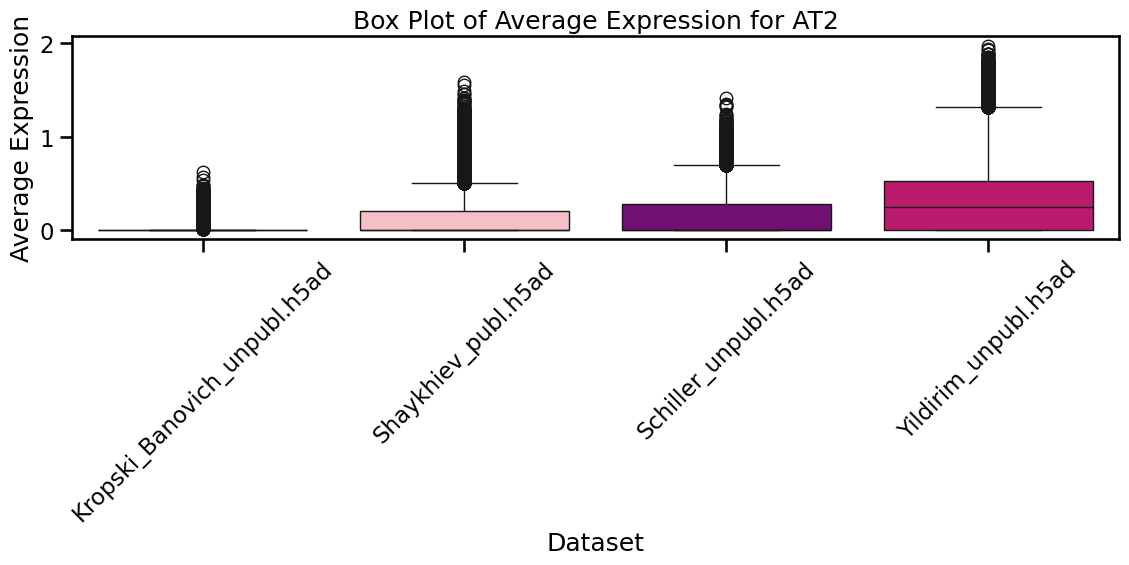

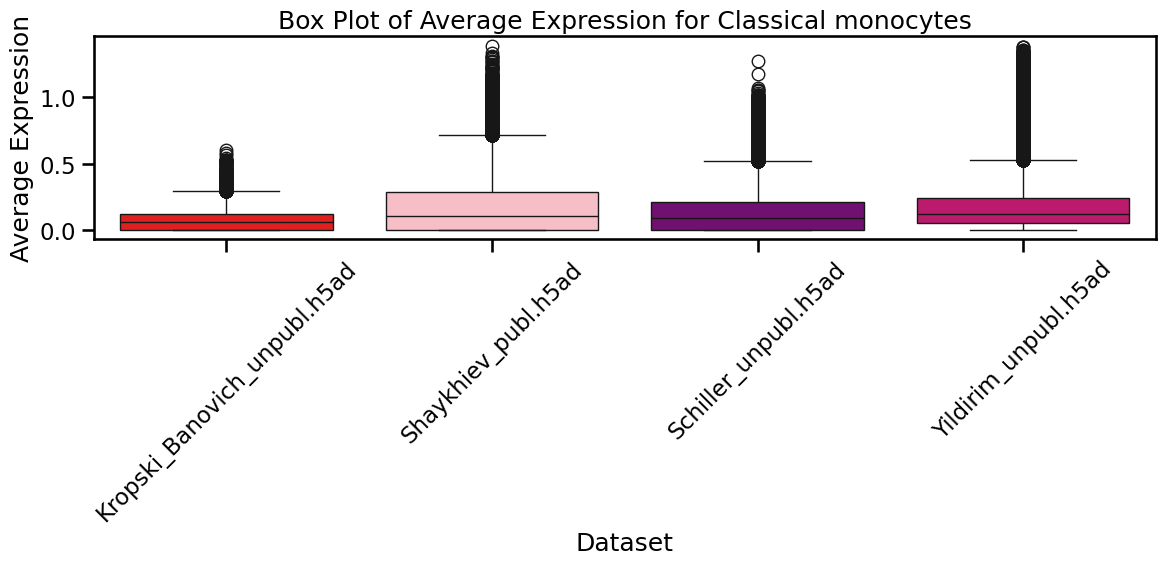

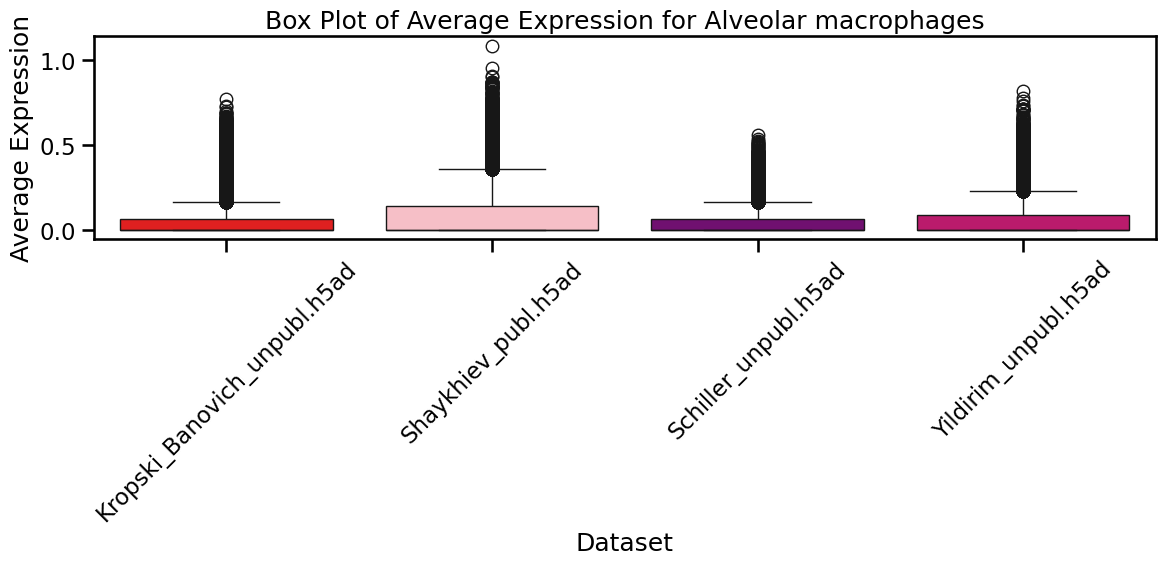

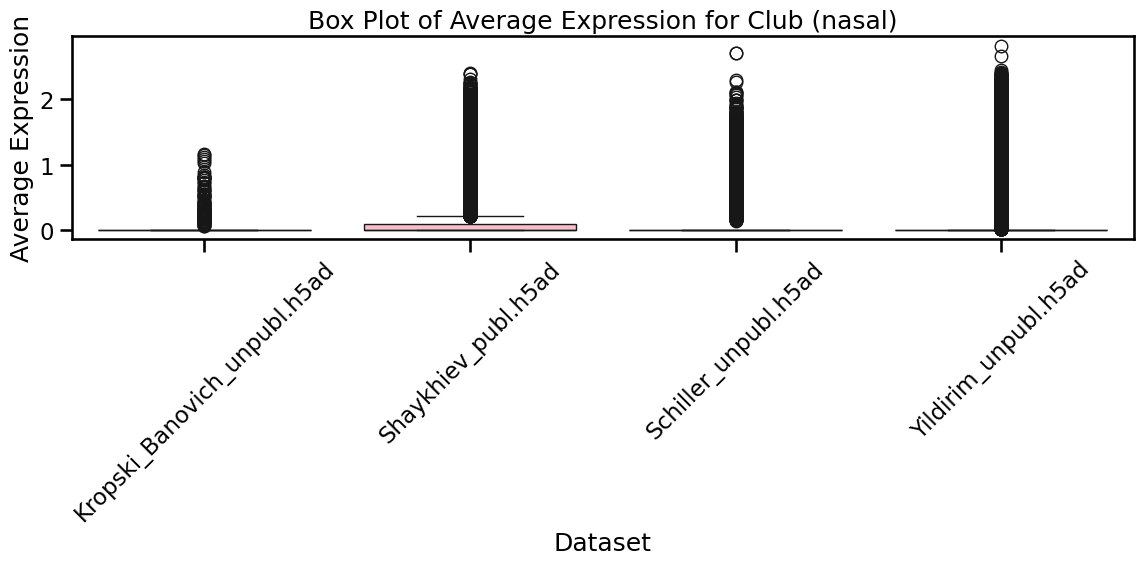

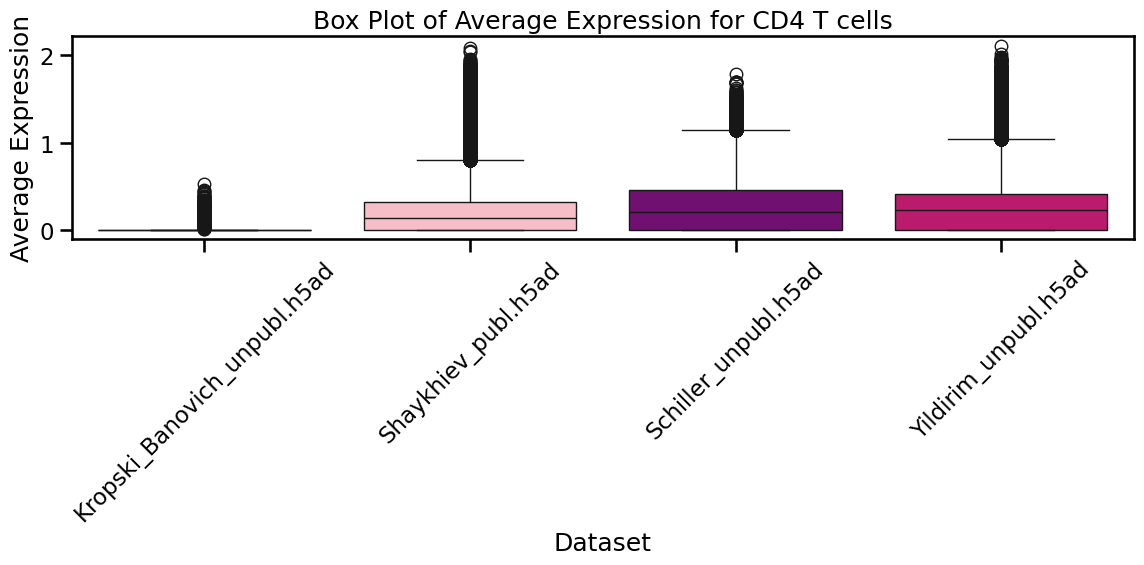

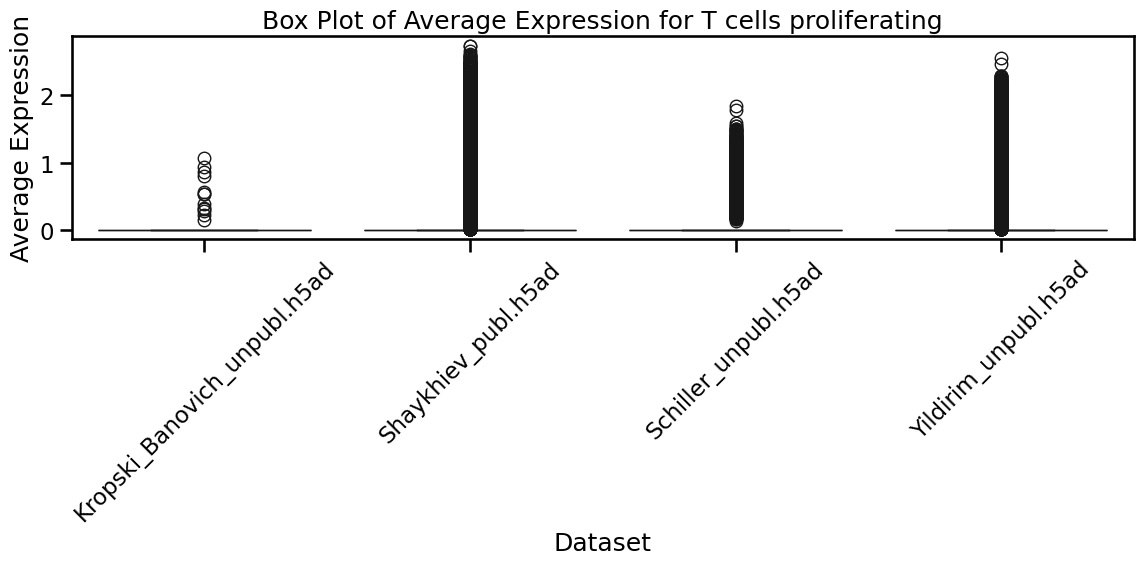

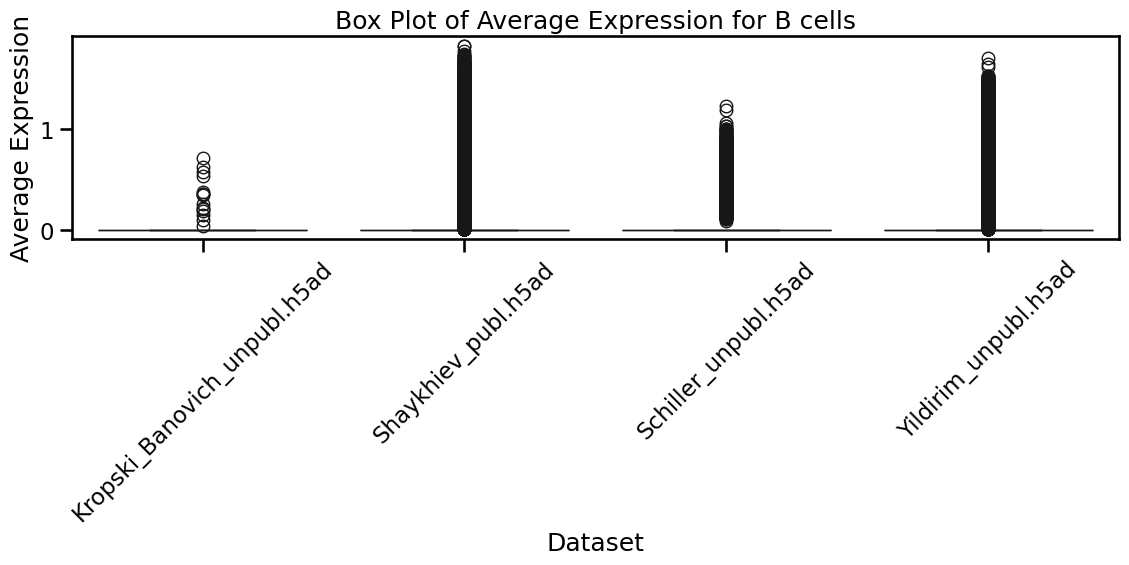

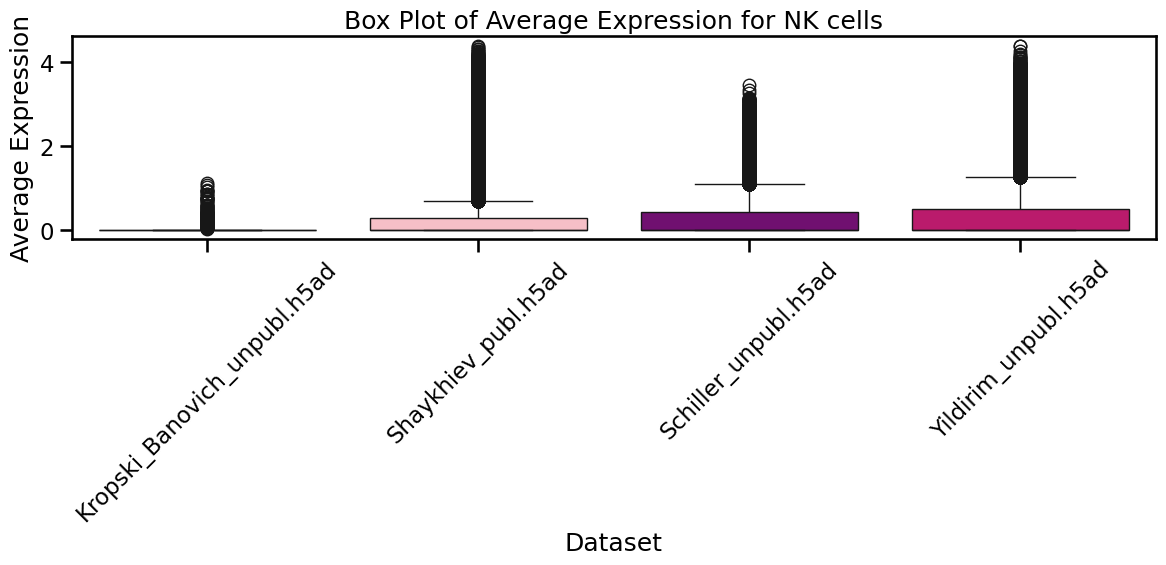

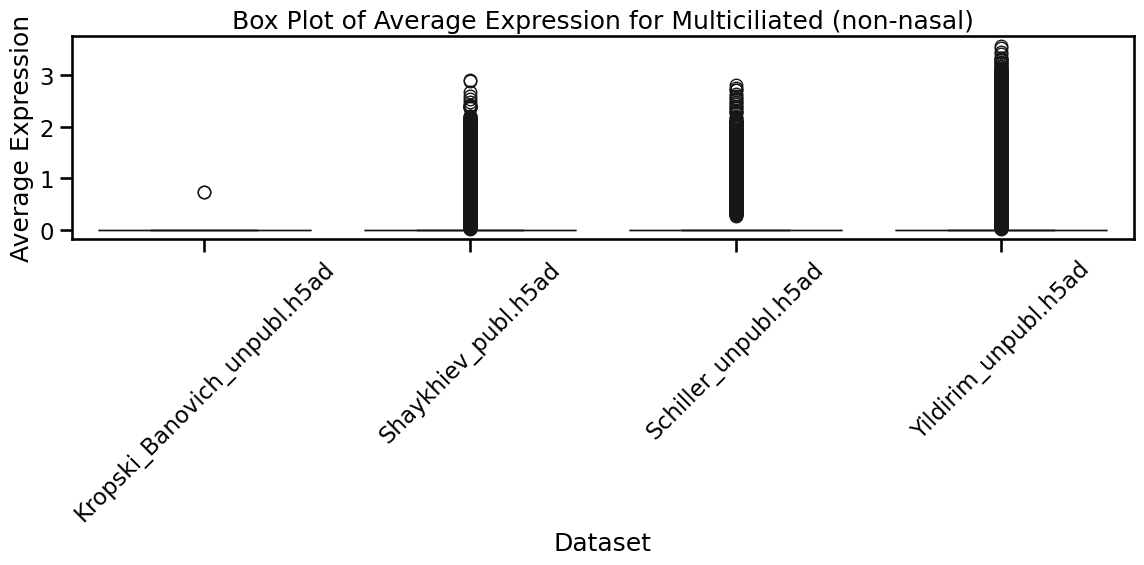

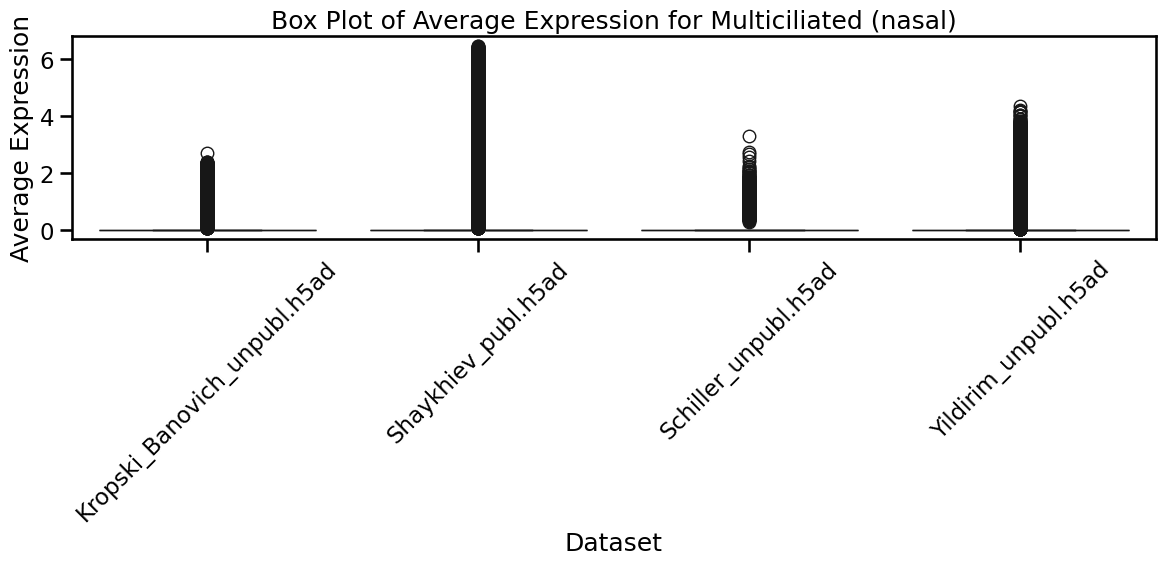

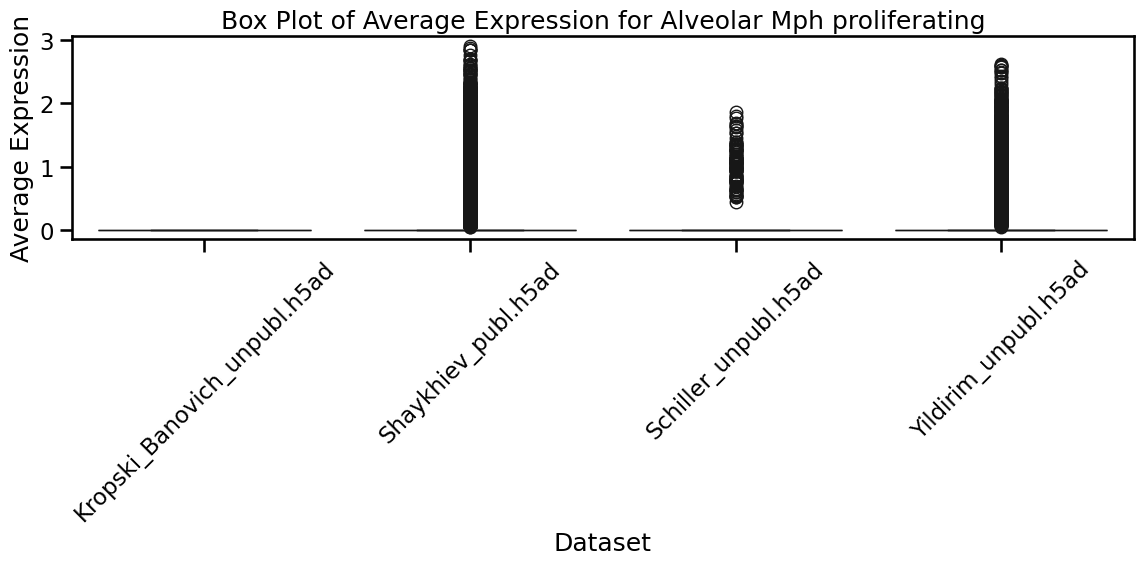

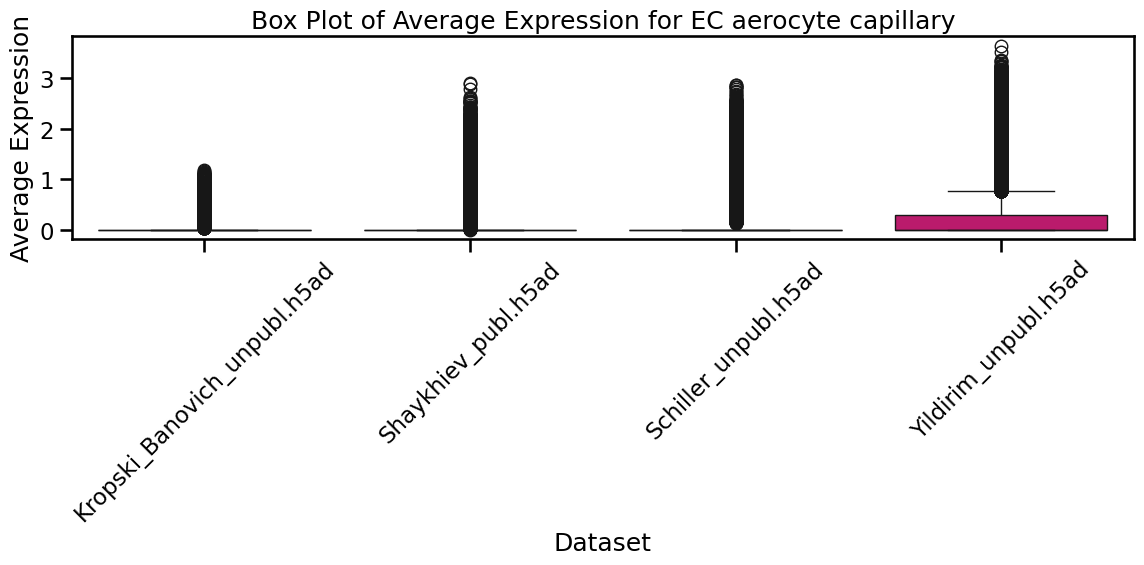

In [22]:
# Initialize a list to store combined data
combined_data = []

# Loop through each dataset for plotting
datasets = [problematic_dataset] + other_copd_datasets
for dataset in datasets:
    mask = adata.obs['file_name'] == dataset
    adata_subset = adata[mask]
    
    # Calculate average expression
    avg_expr_df = calculate_average_expression(adata_subset, marker_genes)
    avg_expr_df['dataset'] = dataset
    combined_data.append(avg_expr_df)

# Combine all datasets
combined_df = pd.concat(combined_data, ignore_index=True)

# Melt the DataFrame for easy plotting
plot_df = combined_df.melt(id_vars=['dataset'], var_name='Cell Type', value_name='Average Expression')

# Create box plots for each cell type
cell_types = plot_df['Cell Type'].unique()
for cell_type in cell_types:
    plt.figure(figsize=(12, 6))
    
    subset = plot_df[plot_df['Cell Type'] == cell_type]
    
    sns.boxplot(data=subset, x='dataset', y='Average Expression', palette=combined_palette)
    
    plt.title(f'Box Plot of Average Expression for {cell_type}')
    plt.xticks(rotation=45)
    plt.ylabel('Average Expression')
    plt.xlabel('Dataset')
    plt.tight_layout()
    plt.show()
